# Dual-Body Dissipation
Joe P. Renaud<sup>1,2,3</sup>, Wade G. Henning<sup>4,2,3</sup>, Prabal Saxena<sup>4,2,3</sup>, Marc Neveu<sup>4,2</sup>, Avi Mandell<sup>2,3</sup>, Terry Hurford<sup>2</sup>

<sub><sup>1: Universities Space Research Association</sub></sup>
<sub><sup>2: NASA Goddard Space Flight Center</sub></sup>
<sub><sup>3: Sellers Exoplanet Environments Collaboration</sub></sup>
<sub><sup>4: University of Maryland, College Park</sub></sup>

This notebook contains additional figures and calculations related to the manuscript: TBD

# Pre-Analysis Setup

In [1]:
analysis_version = '2.0'
analysis_version_save = analysis_version.replace('.', 'p')

import os
import math
import time
import warnings

# Third Party Package Import
import numpy as np
from scipy.constants import G
from scipy.ndimage.filters import gaussian_filter
from numba import njit

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets

# NaNs will pop up in some analysis. Ignore those warnings
_ = np.seterr(invalid='ignore')

In [2]:
%matplotlib notebook

In [3]:
# TidalPy Import
from TidalPy.tools.conversions import semi_a2orbital_motion, orbital_motion2semi_a, rads2days, days2rads
from TidalPy.utilities.numpyHelper.array_other import neg_array_for_log_plot, find_nearest
from TidalPy.graphics.cmaps import vik_map, tofino_map, lajolla_map, lajolla_map_r, cork_map
from TidalPy.constants import radius_earth, mass_earth, mass_solar, radius_solar, au 

# combine them and build a new colormap
_colors = np.vstack((lajolla_map_r(np.linspace(0., 1, 128)), lajolla_map(np.linspace(0., 1, 128))))
divergence_lajolla = mcolors.LinearSegmentedColormap.from_list('divergence_lajolla', _colors)

## Analysis Input Area

In [4]:
auto_save_plots_ck = \
    widgets.Checkbox(value=False, description='Auto Save Plots')

resolution_text = widgets.Label(value='Calculation Resolution:')
resolution_selection = \
    widgets.RadioButtons(
        options=['LowRes-Interactive Mode', 'MedRes', 'HighRes', 'HighRes - Publication Mode - Warning Can Lead to Memory Issues!'],
        value='LowRes-Interactive Mode',
        description='',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='80%', height='80px'))

input_area = widgets.VBox([auto_save_plots_ck, resolution_text, resolution_selection])
input_area

## Define Plot Styles

In [5]:
plt.rcParams.update({'font.size': 14})

satur_perc = .8
vik_N = vik_map.N

# Colorblind safe reds and blues
red = vik_map(math.floor(vik_N * satur_perc))
blue = vik_map(math.floor(vik_N * (1 - satur_perc)))

## Define object parameters

In [6]:
objects = dict()

pluto = {
    'name': 'Pluto',
    'mass': 0.01328e24,
    'radius': 1.1883e6,
    'semi_a': 19.596e6,  # Charon's Semi-Major Axis
    'spin_rate': 2. * np.pi / (86400. * 6.387229),
    'tidal_scale': .1,
    'host': None
}
objects['Pluto'] = pluto

charon = {
    'name': 'Charon',
    'mass': 0.001603e24,
    'radius': 0.606e6,
    'semi_a': 19.596e6,
    'spin_rate': 2. * np.pi / (86400. * 6.387229),
    'tidal_scale': .1,
    'host': pluto
}
objects['Charon'] = charon
pluto['host'] = charon

TRAPPIST1 = {
    'name': 'TRAPPIST-1',
    'mass': 1.6e29,
    'radius': 81.4e6,
    'k2': 0.33,
    'tidal_scale': 1.,
    'host': None
}
objects['TRAPPIST-1'] = TRAPPIST1

TRAPPIST1_e = {
    'name': 'TRAPPIST1-e',
    'mass': 4.6e24,      # Nearly 94% error in this measurement
    'radius': 5.995e6, # About a 5% error in this measurement
    'semi_a': 4.3807e9,         # 3% error
    'tidal_scale': 1.,
    'host': TRAPPIST1
}
objects['TRAPPIST-1 e'] = TRAPPIST1_e

# Proxima data from Suarez Mascareno 2020
Proxima = {
    'name': 'Proxima',
    'mass': 0.1221 * mass_solar, # Mann+2015 via SM2020
    'radius': 0.141 * radius_solar,
    'tidal_scale': 1.,
    'k2': 0.33,
    'host': None
}
objects['Proxima'] = Proxima

Proxima_b = {
    'name': 'Proxima',
    'mass': 1.25 * mass_earth, # Mann+2015 via SM2020 GP+2 column
    'radius': 1.1 * radius_earth, # Total guess. Should be treated as a semi-free parameter based on mass.
    'semi_a': orbital_motion2semi_a(2. * np.pi / (86400. * 5.152), 0.1221 * mass_solar, 1.25 * mass_earth),
    'tidal_scale': 1.,
    'host': Proxima
}
objects['Proxima b'] = Proxima_b

for object_name, object_data in objects.items():

    # Calculate basic geometry
    object_data['volume'] = (4. / 3.) * np.pi * object_data['radius']**3
    object_data['density_bulk'] = object_data['mass'] / object_data['volume']
    object_data['gravity_surface'] = G * object_data['mass'] / object_data['radius']**2
    object_data['beta'] = object_data['radius'] * object_data['gravity_surface'] * object_data['density_bulk']
    object_data['moi'] = (2. / 5.) * object_data['mass'] * object_data['radius']**2
    if 'moi_scale' in object_data:
        object_data['moi'] *= object_data['moi_scale']

    # If satellite, calculate orbital frequency
    if object_data['host'] is not None:
        host = object_data['host']
        object_data['orbital_freq'] = semi_a2orbital_motion(object_data['semi_a'], host['mass'], object_data['mass'])

## Material Properties & Complex Compliance Functions

In [7]:
from TidalPy.rheology.complexCompliance.compliance_models import andrade_array, maxwell_array, sundberg_array, off_array

rock_viscosity = 1.0e22
rock_shear = 5.0e10
ice_viscosity = 1.0e14
ice_shear = 1.e9 # 3.3e9

rheologies = {
    'Andrade': (andrade_array, (0.3, 1.0)),
    'Maxwell': (maxwell_array, tuple()),
    'Sundberg': (sundberg_array, (0.2, 0.02, 0.3, 1.0)),
    'Off': (off_array, tuple())
}

rheologies['Sundberg-Cooper'] = rheologies['Sundberg']

## Setup Tidal Calculation Functions


In [8]:
from TidalPy.tides.mode_manipulation import find_mode_manipulators
from TidalPy.dynamics import spin_rate_derivative, semia_eccen_derivatives_array_dual
from TidalPy.tides.dissipation import calc_tidal_susceptibility

# Tidal dissipation calculator
def build_tide_func(object_dict, host_dict,
                    complex_comp_func=None, complex_comp_input=None, use_ctl_cpl=False, eccentricity_truncation_lvl=10,
                    use_obliquity=True, max_order_l=2):

    # Pull out information from the object & host dictionaries
    object_mass = object_dict['mass']
    object_radius = object_dict['radius']
    object_gravity = object_dict['gravity_surface']
    object_density = object_dict['density_bulk']
    tidal_scale = object_dict['tidal_scale']

    tidal_host_mass = host_dict['mass']

    if use_ctl_cpl:
        # CTL/CPL not supported for l != 2
        max_order_l_to_use = 2
    else:
        max_order_l_to_use = max_order_l

        if complex_comp_input is None or complex_comp_func is None:
            raise Exception

        if complex_comp_input is None:
            complex_comp_input = tuple()


    calculate_terms, collapse_modes, eccentricity_func, inclincation_func = \
        find_mode_manipulators(max_order_l_to_use, eccentricity_truncation_lvl, use_obliquity)

    def calculate_tides_func(orbital_freq, spin_freq, eccentricity_results, obliquity, semi_major_axis=None,
                             shear_modulus=None, viscosity=None, fixed_q=None, k2=None, dt_scale=None):

        if shear_modulus is None:
            shear_modulus = 1.
        compliance = shear_modulus**(-1)

        if semi_major_axis is None:
            semi_major_axis = orbital_motion2semi_a(orbital_freq, tidal_host_mass, object_mass)
            
        # Calculate Obliquity Results
        obliquity_results = inclincation_func(obliquity)

        # Calculate Tidal Susceptibility
        tidal_susceptibility = calc_tidal_susceptibility(tidal_host_mass, object_radius, semi_major_axis)

        # Calculate Tidal Terms
        unique_frequencies, results_by_frequency = \
            calculate_terms(spin_freq, orbital_freq, semi_major_axis, object_radius,
                            eccentricity_results_byorderl=eccentricity_results,
                            obliquity_results_byorderl=obliquity_results)

        # For each unique frequency, calculate complex compliance
        if not use_ctl_cpl:
            compliance_by_freq = tuple([complex_comp_func(freq, compliance, viscosity, *complex_comp_input)
                                  for freq_sig, freq in unique_frequencies.items()])

        else:
            if k2 is None or fixed_q is None:
                raise Exception

            if dt_scale is None:
                # Use CPL method
                compliance_by_freq = tuple([k2 * (1.0 + 1.0j * (1. / fixed_q))
                                      for freq_sig, freq in unique_frequencies.items()])
            else:
                # Use CTL method
                compliance_by_freq = tuple([k2 * (1.0 + 1.0j * (dt_scale * freq))
                                      for freq_sig, freq in unique_frequencies.items()])

        # Collapse Modes
        tidal_heating, dUdM, dUdw, dUdO, love_number, negative_imk = \
            collapse_modes(object_gravity, object_radius, object_density,
                           shear_modulus, tidal_scale,
                           tidal_host_mass,
                           tidal_susceptibility,
                           compliance_by_freq,
                           results_by_frequency,
                           max_order_l=max_order_l, cpl_ctl_method=use_ctl_cpl)

        return tidal_heating, (dUdM, dUdw, dUdO), love_number, negative_imk

    return calculate_tides_func, eccentricity_func


# Tidal derivative calculator
def build_derivative_func(object1_dict, object2_dict):

    # Pull out data from dictionaries
    obj1_mass = object1_dict['mass']
    obj1_moi = object1_dict['moi']
    obj2_mass = object2_dict['mass']
    obj2_moi = object2_dict['moi']

    @njit
    def calc_derivatives_func(semi_major_axis, orbital_freq, eccentricity, obj1_partial_derivs, obj2_partial_derivs):


        dUdM_obj1, dUdw_obj1, dUdO_obj1 = obj1_partial_derivs
        dUdM_obj2, dUdw_obj2, dUdO_obj2 = obj2_partial_derivs

        # Calculate change in spin-rate
        dspin_dt_obj1 = spin_rate_derivative(dUdO_obj1, obj1_moi, obj2_mass)
        dspin_dt_obj2 = spin_rate_derivative(dUdO_obj2, obj2_moi, obj1_mass)

        # Calculate dual dissipation derivatives
        da_dt, de_dt = semia_eccen_derivatives_array_dual(semi_major_axis, orbital_freq, eccentricity,
                                                          obj1_mass, dUdM_obj1, dUdw_obj1,
                                                          obj2_mass, dUdM_obj2, dUdw_obj2)

        # Convert results to something more readable
        # # Convert from "per sec" to "per yr"
        da_dt *= 3.154e7
        de_dt *= 3.154e7

        # # Convert semi-a to km instead of m
        da_dt = da_dt / 1000.

        # # Convert from "per sec^2" to "per yr^2"
        dspin_dt_obj1 *= 3.154e7**2
        dspin_dt_obj2 *= 3.154e7**2

        # # Convert radians to degs
        dspin_dt_obj1 *= (360. / (2. * np.pi))
        dspin_dt_obj2 *= (360. / (2. * np.pi))

        return dspin_dt_obj1, dspin_dt_obj2, da_dt, de_dt

    return calc_derivatives_func

### Default Dual-Body Targets

In [9]:
default_obj1 = pluto
default_obj2 = charon
default_obj1_rheology = rheologies['Sundberg']
default_obj2_rheology = rheologies['Sundberg']

default_obj1_tide_calc, _ = \
    build_tide_func(default_obj1, default_obj2, *default_obj1_rheology, use_ctl_cpl=False)
default_obj2_tide_calc, default_eccentricity_func = \
    build_tide_func(default_obj2, default_obj1, *default_obj2_rheology, use_ctl_cpl=False)

default_derivative_calc = build_derivative_func(default_obj1, default_obj2)

### Other Helper Functions

In [10]:
def get_resolution():
    
    if resolution_selection.value == 'LowRes-Interactive Mode':
        one_d_res = 5000
    elif resolution_selection.value == 'MedRes':
        one_d_res = 50000
    elif resolution_selection.value == 'HighRes':
        one_d_res = 350000
    elif resolution_selection.value == 'HighRes - Publication Mode - Warning Can Lead to Memory Issues!':
        one_d_res = 722500
    else:
        one_d_res = 10
    
    two_d_res = int(math.floor(one_d_res**(1/2)))
    
    return one_d_res, two_d_res

In [11]:
breakpoint()

--Call--
> c:\programdata\anaconda3\lib\site-packages\ipython\core\displayhook.py(252)__call__()
-> def __call__(self, result=None):
(Pdb) q


BdbQuit: 

# Main Analysis & Plotting
## NSR Plots
### Truncation Level Differences

In [ ]:
def truncation_level_plots(target_object, host_object, obliquity=0.,
                           host_k2=0.33, host_q=5000.,
                           target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                        zpoints=np.linspace(-4, 4, 60), zticks=(-4, -2, 0, 2, 4),
                        ztick_names = ('$-10^{4}$', '$-10^{2}$', '$0$', '$10^{2}$', '$10^{4}$'),
                           add_save_name: str = None,
                           save_fig=auto_save_plots_ck.value):
    
    print('This plot can take a while the first time it is run after a restart (functions are compiling).')
    time_i = time.time()
    # Pull out data
    constant_orbital_freq = target_object['orbital_freq']
    constant_host_spin_rate = constant_orbital_freq
    host_obliquity = 0.
    derivative_calc = build_derivative_func(host_object, target_object)
    constant_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host_object['mass'], target_object['mass'])

    # Domains
    oned_n, twod_n = get_resolution()
    eccentricity_domain = np.logspace(-2, 0., twod_n)
    spin_scale_domain = np.linspace(0., 3., twod_n)
    #    Make sure to hit resonances
    spin_scale_domain_res = np.asarray([0.5, 1., 1.5, 2., 2.5, 3.])
    spin_scale_domain = np.concatenate((spin_scale_domain, spin_scale_domain_res))
    spin_scale_domain = np.sort(spin_scale_domain)
    spin_domain = spin_scale_domain * constant_orbital_freq
    eccentricity, spin_rate = np.meshgrid(eccentricity_domain, spin_domain)
    shape = eccentricity.shape
    eccentricity = eccentricity.flatten()
    spin_rate = spin_rate.flatten()

    # Make sure that all input arrays have the correct shape
    x = eccentricity_domain
    y = spin_scale_domain
    obliquity *= np.ones_like(eccentricity)
    host_obliquity *= np.ones_like(eccentricity)
    constant_orbital_freq *= np.ones_like(spin_rate)
    constant_semi_major_axis *= np.ones_like(spin_rate)
    constant_host_spin_rate *= np.ones_like(constant_orbital_freq)
    #   Find spin_sync index
    sync_index = find_nearest(spin_scale_domain, 1.)

    # Cases that are plotted (must be equal to 4, must have the format (order-l, eccentricity_trunc)
    cases = [(2, 2), (2, 6), (2, 10), (2, 20)]
    case_line_styles = ['-', '--', '-.', ':']
    case_names = ['$\\mathcal{O}(e^{' + f'{trunc_level}' + '}$)' if order_l == 2 
                  else '$l = ' + order_l + '\\mathcal{O}(e^{' + f'{trunc_level}' + '}$)'
                  for order_l, trunc_level in cases]

    # Setup plots
    #    Contour Figure
    fig_contours = plt.figure(figsize=(6.75*1.75, 4.8), constrained_layout=True)
    ratios = (.249, .249, .249, .249, .02)
    gs_contours = GridSpec(1, 5, figure=fig_contours, width_ratios=ratios)
    case_contour_axes = [fig_contours.add_subplot(gs_contours[0, i]) for i in range(4)]
    colorbar_ax = fig_contours.add_subplot(gs_contours[0, 4])

    #    Spin-sync Figure
    fig_sync, sync_axes = plt.subplots(ncols=2, figsize=(1.5 * 6.4, 4.8))
    fig_sync.subplots_adjust(wspace=0.3)
    fig_sync.suptitle('Spin Synchronous', fontsize=16)
    sync_heating_ax = sync_axes[0]
    sync_eccen_ax = sync_axes[1]

    # Labels
    for ax in [sync_heating_ax, sync_eccen_ax] + case_contour_axes:
        ax.set(xlabel='Eccentricity', xscale='log')
        
    for ax in fig_contours.get_axes():
        ax.label_outer()

    case_contour_axes[0].set(ylabel='$\\dot{\\theta} \\; / \\; n$')
    sync_heating_ax.set(ylabel='Tidal Heating [W]', yscale='log')
    sync_eccen_ax.set(ylabel='$\\dot{e}$ [yr$^{-1}$]', yscale='log')

    for case_i, (order_l, eccentricity_trunc) in enumerate(cases):

        # Need to build a new tidal calculation function based on this truncation level
        rheology = rheologies[target_rheo]
        target_tide_calc, eccentricity_func = \
            build_tide_func(target_object, host_object, *rheology, use_ctl_cpl=False,
                            eccentricity_truncation_lvl=eccentricity_trunc, max_order_l=order_l)

        # For this analysis we always assume the host body is dissipating like a constant fixed q.
        #     This will not affect the contours, only the orbital derivatives.
        # TODO: For the time being the fixed-Q method only allows for order-l = 2
        if order_l > 2:
            warnings.warn('Order l > 2 case encountered. Tidal Host forced to used l=2. Will not affect contour plots.')
        host_tide_calc, _ = build_tide_func(host_object, target_object, *rheology, use_ctl_cpl=True,
                                         eccentricity_truncation_lvl=eccentricity_trunc, max_order_l=2)

        # Calculate tides
        eccentricity_results = eccentricity_func(eccentricity)
        
        tidal_heating_targ, partial_derivatives_targ, love_number_targ, negative_imk_targ = \
            target_tide_calc(constant_orbital_freq, spin_rate, eccentricity_results, obliquity,
                             semi_major_axis=constant_semi_major_axis,
                             shear_modulus=target_shear, viscosity=target_viscosity)

        tidal_heating_host, partial_derivatives_host, love_number_host, negative_imk_host = \
            host_tide_calc(constant_orbital_freq, constant_host_spin_rate, eccentricity_results, host_obliquity,
                           semi_major_axis=constant_semi_major_axis,
                           fixed_q=host_q, k2=host_k2, dt_scale=None)

        # Calculate Derivatives
        dspin_dt_host, dspin_dt_targ, da_dt, de_dt = \
            derivative_calc(constant_semi_major_axis, constant_orbital_freq, eccentricity,
                            partial_derivatives_host, partial_derivatives_targ)

        # Reshape
        tidal_heating_targ = tidal_heating_targ.reshape(shape)
        dspin_dt_targ = dspin_dt_targ.reshape(shape)
        de_dt = de_dt.reshape(shape)

        # Prep for log plotting
        dspin_dt_targ_pos, dspin_dt_targ_neg = neg_array_for_log_plot(dspin_dt_targ)
        de_dt_pos, de_dt_neg = neg_array_for_log_plot(de_dt)

        # Make data Symmetric Log (for negative logscale plotting)
        logpos = np.log10(np.copy(dspin_dt_targ_pos))
        logpos[logpos < 0.] = 0.
        negative_index = ~np.isnan(dspin_dt_targ_neg)
        logneg = np.log10(dspin_dt_targ_neg[negative_index])
        logneg[logneg < 0.] = 0.
        dspin_dt_targ_combo = logpos
        dspin_dt_targ_combo[negative_index] = -logneg

        # Plot Contours
        case_name = case_names[case_i]
        contour_ax = case_contour_axes[case_i]
        contour_ax.set(title=case_name)
        cb_data = contour_ax.contourf(x, y, dspin_dt_targ_combo, zpoints, cmap=vik_map)
    
        for c in cb_data.collections:
            c.set_edgecolor("face")
        
        # Plot Spin Sync
        case_style = case_line_styles[case_i]
        #    Find sync data
        tidal_heating_sync = tidal_heating_targ[sync_index, :]
        de_dt_neg_sync = de_dt_neg[sync_index, :]
        de_dt_pos_sync = de_dt_pos[sync_index, :]
        #    Plot
        sync_heating_ax.plot(x, tidal_heating_sync, c=red, ls=case_style, label=case_name)
        sync_eccen_ax.plot(x, de_dt_neg_sync, c=blue, ls=case_style, label=case_name)
        sync_eccen_ax.plot(x, de_dt_pos_sync, c=red, ls=case_style)
        
        print(f'Case {case_i} completed.')

    # Add Colorbar
    cb = plt.colorbar(cb_data, pad=0.03, cax=colorbar_ax, ticks=zticks)
    spaces = '$' + '\\; '*14 + '$'
    cb.set_label('Decelerating ' + spaces + 'Accelerating\n$\\ddot{\\theta}$ [deg yr$^{-2}$]')
    cb.ax.set_yticklabels(ztick_names)
    
    # Add Spin-Sync Legend
    custom_lines = [Line2D([0], [0], color='k', lw=2, ls=style) for style in case_line_styles]
    sync_heating_ax.legend(custom_lines, case_names, loc='upper left')

    # Add Annotations
    #    3:2 Arrows
    arrow_ax = case_contour_axes[0]
    arrow_ax.annotate(
            '', xy=(.9, .75), xytext=(.9, .51), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops={'arrowstyle': '<-', 'lw': 2})
    arrow_ax.annotate(
            '', xy=(.9, .15), xytext=(.9, .49), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops={'arrowstyle': '<-', 'lw': 2})
    arrow_ax.text(.27, .23, 'Accelerating\nSpin-Rate', fontsize=12, ha='center')
    arrow_ax.text(.27, 2.35, 'Decelerating\nSpin-Rate', fontsize=12, ha='center')
    arrow_ax.text(.07, 1.65, 'Circularization &\nResonance Fall-Off', fontsize=12, ha='center')

    #    3:2 R to L
    arrow_ax.annotate(
            '', xy=(.85, .53), xytext=(.5, .53), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops={'arrowstyle': '<-', 'lw': 2})
    arrow_ax.annotate(
            '', xy=(.4, .53), xytext=(.25, .34), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops={'arrowstyle': '<-', 'lw': 2})

    #    Add Mercury Marker
    merc_ax = case_contour_axes[2]
    merc_x = 0.205630
    merc_y = 1.5
    merc_ax.text(.055, merc_y * 1.05, 'Mercury', fontsize=12)
    merc_ax.plot([merc_x], [merc_y], 'kx')
    
    time_f = time.time() - time_i
    print(f'Calculations and plot setup took {time_f:0.1f} seconds.')

    if save_fig:
        save_name = analysis_version_save + 'TruncationPlot_' + target_object['name'] + '_' + host_object['name']
        if add_save_name is not None:
            save_name = save_name + '_' + add_save_name

        fig_contours.savefig(save_name + '_Contours.pdf')
        fig_sync.tight_layout(rect=[0, 0, 1, 0.95])
        fig_sync.savefig(save_name + '_SpinSync.pdf')

    plt.show()
    return fig_contours, fig_sync

#### Basic Truncation Comparison - No Obliquity

In [ ]:
truncation_level_plots(TRAPPIST1_e, TRAPPIST1, obliquity=0.,
                       target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                       add_save_name=None)

#### Basic Truncation Comparison - 20 deg Obliquity

In [ ]:
truncation_level_plots(TRAPPIST1_e, TRAPPIST1, obliquity=np.radians(35.),
                       target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                       add_save_name='Oblquity35')

### Single Truncation Contours

In [ ]:
def single_contour_plot(target_object, host_object, obliquity=0.,
                        target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                        host_k2=0.33, host_q=5000.,
                        order_l: int = 2, eccentricity_truncation: int = 10,
                        zpoints=np.linspace(-5, 5, 60), zticks=(-5, -3, -1, 0, 1, 3, 5),
                        ztick_names = ('$-10^{5}$', '$-10^{3}$', '$-10^{1}$', '$0$', '$10^{1}$', '$10^{3}$', '$10^{5}$'),   
                        draw_resonance_lines: bool = True,
                        title = None, add_save_name: str = None, save_fig=auto_save_plots_ck.value):
    
    print('This plot can take a while the first time it is run after a restart (functions are compiling).')
    # Pull out data
    constant_orbital_freq = target_object['orbital_freq']
    constant_host_spin_rate = constant_orbital_freq
    host_obliquity = 0.
    derivative_calc = build_derivative_func(host_object, target_object)
    constant_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host_object['mass'], target_object['mass'])

    # Domains
    oned_n, twod_n = get_resolution()
    eccentricity_domain = np.logspace(-2, 0., twod_n)
    spin_scale_domain = np.linspace(0., 3., twod_n+1)
    #    Make sure to hit resonances
    spin_scale_domain_res = np.asarray([0.5, 1., 1.5, 2., 2.5, 3.])
    spin_scale_domain = np.concatenate((spin_scale_domain, spin_scale_domain_res))
    spin_scale_domain = np.sort(spin_scale_domain)
    spin_domain = spin_scale_domain * constant_orbital_freq
    eccentricity, spin_rate = np.meshgrid(eccentricity_domain, spin_domain)
    shape = eccentricity.shape
    eccentricity = eccentricity.flatten()
    spin_rate = spin_rate.flatten()

    # Make sure that all input arrays have the correct shape
    x = eccentricity_domain
    y = spin_scale_domain
    min_y = np.min(y)
    obliquity *= np.ones_like(eccentricity)
    host_obliquity *= np.ones_like(eccentricity)
    constant_orbital_freq *= np.ones_like(spin_rate)
    constant_semi_major_axis *= np.ones_like(spin_rate)
    constant_host_spin_rate *= np.ones_like(constant_orbital_freq)
    #   Find spin_sync index
    sync_index = find_nearest(spin_scale_domain, 1.)
    
    # Single plot to compare resonance heating rates
    fig_single, ax_sig = plt.subplots(figsize=(6.4, 4.8), constrained_layout=True)
    ax_sig.set(xlabel='Eccentricity', xscale='log', ylabel='Tidal Heating [W]', yscale='log')

    # Setup plots
    #    Contour Figure
    fig_contour, ax = plt.subplots(figsize=(6.4, 4.8), constrained_layout=True)

    # Labels
    ax.set(xlabel='Eccentricity', xscale='log', ylabel='$\\dot{\\theta} \\; / \\; n$')

    # Need to build a new tidal calculation function based on this truncation level
    rheology = rheologies[target_rheo]
    target_tide_calc, eccentricity_func = \
        build_tide_func(target_object, host_object, *rheology, use_ctl_cpl=False,
                        eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=order_l)

    # For this analysis we always assume the host body is dissipating like a constant fixed q.
    #     This will not affect the contours, only the orbital derivatives.
    # TODO: For the time being the fixed-Q method only allows for order-l = 2
    if order_l > 2:
        warnings.warn('Order l > 2 case encountered. Tidal Host forced to used l=2. Will not affect contour plots.')
    host_tide_calc, _ = \
        build_tide_func(host_object, target_object, *rheology, use_ctl_cpl=True,
                        eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=2)

    # Calculate tides
    eccentricity_results = eccentricity_func(eccentricity)
    
    tidal_heating_targ, partial_derivatives_targ, love_number_targ, negative_imk_targ = \
        target_tide_calc(constant_orbital_freq, spin_rate, eccentricity_results, obliquity,
                         semi_major_axis=constant_semi_major_axis,
                         shear_modulus=target_shear, viscosity=target_viscosity)

    tidal_heating_host, partial_derivatives_host, love_number_host, negative_imk_host = \
        host_tide_calc(constant_orbital_freq, constant_host_spin_rate, eccentricity_results, host_obliquity,
                       semi_major_axis=constant_semi_major_axis,
                       fixed_q=host_q, k2=host_k2, dt_scale=None)

    # Calculate Derivatives
    dspin_dt_host, dspin_dt_targ, da_dt, de_dt = \
        derivative_calc(constant_semi_major_axis, constant_orbital_freq, eccentricity,
                        partial_derivatives_host, partial_derivatives_targ)

    # Reshape
    tidal_heating_targ = tidal_heating_targ.reshape(shape)
    dspin_dt_targ = dspin_dt_targ.reshape(shape)
    de_dt = de_dt.reshape(shape)

    # Prep for log plotting
    dspin_dt_targ_pos, dspin_dt_targ_neg = neg_array_for_log_plot(dspin_dt_targ)
    
    tidal_heating_targ_log = np.log10(tidal_heating_targ)
    de_dt_pos, de_dt_neg = neg_array_for_log_plot(de_dt)

    # Make data Symmetric Log (for negative logscale plotting)
    logpos = np.log10(np.copy(dspin_dt_targ_pos))
    logpos[logpos < 0.] = 0.
    negative_index = ~np.isnan(dspin_dt_targ_neg)
    logneg = np.log10(dspin_dt_targ_neg[negative_index])
    logneg[logneg < 0.] = 0.
    dspin_dt_targ_combo = logpos
    dspin_dt_targ_combo[negative_index] = -logneg

    # Plot Contours
    cb_data = ax.contourf(x, y, dspin_dt_targ_combo, zpoints, cmap=vik_map)
    
    for c in cb_data.collections:
        c.set_edgecolor("face")
    
    # Add Resonances to Signle Plot
    resonances = {'-': 1., '--': 1.5, '-.': 2., ':': 2.5}
    for res_ls, res in resonances.items():
        y_index = find_nearest(y, res)
        heating = tidal_heating_targ[y_index, :]
        res_label = '$\\dot{\\theta}/n=' + f'{res}' + '$'
        ax_sig.plot(x, heating, ls=res_ls, label=res_label)
    ax_sig.legend(loc='best')

    # Print minimum eccentricity for a higher order lock
    print('Minimum Eccentricities for Resonance Locks:')
    for resonance in spin_scale_domain_res:
        y_coord = find_nearest(y, resonance-0.006)
        y_value = y[y_coord]
        dspin_dt_at_res = dspin_dt_targ_combo[y_coord, :]
        cross_coord = find_nearest(dspin_dt_at_res, 0.)
        deriv_value = dspin_dt_targ_combo[y_coord, cross_coord]
        print(f'\tO/n = {resonance}')
        print(f'\tO/n real = {y_value:0.3f}')
        if abs(deriv_value) > 0.5:
            print('\tNo Lock')
        else:
            min_e = eccentricity_domain[cross_coord]
            if draw_resonance_lines:
                ax.plot([min_e, min_e], [min_y, y_value + 0.01], ls=':', c='k')
                ax_sig.axvline(x=min_e, ls=':', c='k')
            print(f'\tdO/dt = {deriv_value:0.3f}')
            print(f'\te_min = {min_e:0.5f}')
        print('-------')

    # Add Colorbar
    cb = plt.colorbar(cb_data, pad=0.03, ticks=zticks)
    spaces = '$' + '\\; '*19 + '$'
    cb.set_label('Decelerating ' + spaces + 'Accelerating\n$\\ddot{\\theta}$ [deg yr$^{-2}$]')
    cb.ax.set_yticklabels(ztick_names)
    
    # Add title
    if title is not None:
        ax.set(title=title)
    
    if save_fig:
        save_name = analysis_version_save + '_SingleContourPlot_' + target_object['name'] + '_' + host_object['name']
        if add_save_name is not None:
            save_name = save_name + '_' + add_save_name

        fig_contour.savefig(save_name + 'Contour.pdf')
        fig_single.savefig(save_name + 'SingleHeating.pdf')

#### Regular

In [ ]:
single_contour_plot(TRAPPIST1_e, TRAPPIST1, obliquity=0.,
                    target_viscosity=rock_viscosity/100, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                    host_k2=0.33, host_q=5000.,
                    order_l=2, eccentricity_truncation=20,
                    zpoints=np.linspace(-5, 5, 40), zticks=(-5, -3, -1, 0, 1, 3, 5),
                    title=None, add_save_name='Regular')

#### Low Viscosity

In [ ]:
single_contour_plot(TRAPPIST1_e, TRAPPIST1, obliquity=0.,
                    target_viscosity=ice_viscosity, target_shear=ice_shear, target_rheo='Sundberg-Cooper',
                    host_k2=0.33, host_q=5000.,
                    order_l=2, eccentricity_truncation=20,
                    zpoints=np.linspace(-5, 5, 60), zticks=(-5, -3, -1, 0, 1, 3, 5),
                    draw_resonance_lines=False,
                    title='Low Viscosity', add_save_name='Viscosity1e14')

#### Proxima

In [ ]:
single_contour_plot(Proxima_b, Proxima, obliquity=0.,
                    target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                    host_k2=0.33, host_q=5000.,
                    order_l=2, eccentricity_truncation=20,
                    zpoints=np.linspace(-5, 5, 40), zticks=(-5, -3, -1, 0, 1, 3, 5),
                    title='Proxima b', add_save_name='Regular')

### Double Contour Plots

In [ ]:
def double_contour_plot(target_object, host_object, obliquity=0.,
                        target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                        host_k2=0.33, host_q=5000.,
                        order_l: int = 2, eccentricity_truncation: int = 10,
                        zpoints=np.linspace(-5, 5, 60), zticks=(-5, -3, -1, 0, 1, 3, 5),
                        ztick_names = ('$-10^{5}$', '$-10^{3}$', '$-10^{1}$', '$0$', '$10^{1}$', '$10^{3}$', '$10^{5}$'), 
                        draw_resonance_lines: bool = True,
                        text_2x: float = None, text_2y: float = None, text_2: str = None,
                        orbital_period_replacement: float = None,
                        title_1 = None, title_2 = None, add_save_name: str = None, save_fig=auto_save_plots_ck.value):
    
    print('This plot can take a while the first time it is run after a restart (functions are compiling).')
    # Pull out data
    constant_orbital_freq = target_object['orbital_freq']
    if orbital_period_replacement is not None:
        old_orbital_period = rads2days(constant_orbital_freq)
        old_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host_object['mass'], target_object['mass'])
        print(f'Old Orbital Period: {old_orbital_period:0.2f} Days')
        print(f'Old Semi-Major Axis: {old_semi_major_axis/1000:0.1f} km')
        constant_orbital_freq = days2rads(orbital_period_replacement)
        constant_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host_object['mass'], target_object['mass'])
    else:
        constant_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host_object['mass'], target_object['mass'])
    
    print(f'Orbital Period: {rads2days(constant_orbital_freq):0.2f} Days')
    print(f'Semi-Major Axis: {constant_semi_major_axis/1000:0.1f} km')
    constant_host_spin_rate = constant_orbital_freq
    host_obliquity = 0.
    derivative_calc = build_derivative_func(host_object, target_object)

    # Domains
    oned_n, twod_n = get_resolution()
    eccentricity_domain = np.logspace(-2, 0., twod_n)
    spin_scale_domain = np.linspace(0., 3., twod_n)
    #    Make sure to hit resonances
    spin_scale_domain_res = np.asarray([0.5, 1., 1.5, 2., 2.5, 3.])
    spin_scale_domain = np.concatenate((spin_scale_domain, spin_scale_domain_res))
    spin_scale_domain = np.sort(spin_scale_domain)
    spin_domain = spin_scale_domain * constant_orbital_freq
    eccentricity, spin_rate = np.meshgrid(eccentricity_domain, spin_domain)
    shape = eccentricity.shape
    eccentricity = eccentricity.flatten()
    spin_rate = spin_rate.flatten()

    # Make sure that all input arrays have the correct shape
    x = eccentricity_domain
    y = spin_scale_domain
    min_y = np.min(y)
    obliquity *= np.ones_like(eccentricity)
    host_obliquity *= np.ones_like(eccentricity)
    constant_orbital_freq *= np.ones_like(spin_rate)
    constant_semi_major_axis *= np.ones_like(spin_rate)
    constant_host_spin_rate *= np.ones_like(constant_orbital_freq)
    #   Find spin_sync index
    sync_index = find_nearest(spin_scale_domain, 1.)
    
    # Need to build a new tidal calculation function based on this truncation level
    rheology = rheologies[target_rheo]

    # For this analysis we always assume the host body is dissipating like a constant fixed q.
    #     This will not affect the contours, only the orbital derivatives.
    # TODO: For the time being the fixed-Q method only allows for order-l = 2
    if order_l > 2:
        warnings.warn('Order l > 2 case encountered. Tidal Host forced to used l=2. Will not affect contour plots.')
    host_tide_calc, _ = \
        build_tide_func(host_object, target_object, *rheology, use_ctl_cpl=True,
                        eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=2)

    # Setup plots
    #    Contour Figure
    fig_contour = plt.figure(figsize=(6.4*1.75, 4.8), constrained_layout=True)
    ratios = (0.49, 0.49, 0.02)
    gs = GridSpec(1, 3, figure=fig_contour, width_ratios=ratios, wspace=0.2)
    axes = [fig_contour.add_subplot(gs[0, i]) for i in range(2)]
    colorbar_ax = fig_contour.add_subplot(gs[0, 2])
    
    for ax in fig_contour.get_axes():
        ax.label_outer()
    
    for ax_i, ax in enumerate(axes):
        
         # Labels
        ax.set(xlabel='Eccentricity', xscale='log', ylim=(0., spin_scale_domain_res[-1]))
        
        if ax_i == 0:
            
            target_tide_calc, eccentricity_func = \
                build_tide_func(target_object, host_object, *rheology, use_ctl_cpl=False,
                                eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=2)
    
            # Regular Plot
            ax.set(ylabel='$\\dot{\\theta} \\; / \\; n$')
            
            # Calculate tides
            eccentricity_results = eccentricity_func(eccentricity)
            
            tidal_heating_targ, partial_derivatives_targ, love_number_targ, negative_imk_targ = \
                target_tide_calc(constant_orbital_freq, spin_rate, eccentricity_results, 0.,
                                 semi_major_axis=constant_semi_major_axis,
                                 shear_modulus=target_shear, viscosity=target_viscosity)

            tidal_heating_host, partial_derivatives_host, love_number_host, negative_imk_host = \
                host_tide_calc(constant_orbital_freq, constant_host_spin_rate, eccentricity_results, 0.,
                               semi_major_axis=constant_semi_major_axis,
                               fixed_q=host_q, k2=host_k2, dt_scale=None)

            # Calculate Derivatives
            dspin_dt_host, dspin_dt_targ, da_dt, de_dt = \
                derivative_calc(constant_semi_major_axis, constant_orbital_freq, eccentricity,
                                partial_derivatives_host, partial_derivatives_targ)
            
            # Add title
            if title_1 is not None:
                ax.set(title=title_1)
            
        else:
            
            target_tide_calc, eccentricity_func = \
                build_tide_func(target_object, host_object, *rheology, use_ctl_cpl=False,
                                eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=order_l)
            
            # Calculate tides
            eccentricity_results = eccentricity_func(eccentricity)
            
            tidal_heating_targ, partial_derivatives_targ, love_number_targ, negative_imk_targ = \
                target_tide_calc(constant_orbital_freq, spin_rate, eccentricity_results, obliquity,
                                 semi_major_axis=constant_semi_major_axis,
                                 shear_modulus=target_shear, viscosity=target_viscosity)

            tidal_heating_host, partial_derivatives_host, love_number_host, negative_imk_host = \
                host_tide_calc(constant_orbital_freq, constant_host_spin_rate, eccentricity_results, host_obliquity,
                               semi_major_axis=constant_semi_major_axis,
                               fixed_q=host_q, k2=host_k2, dt_scale=None)

            # Calculate Derivatives
            dspin_dt_host, dspin_dt_targ, da_dt, de_dt = \
                derivative_calc(constant_semi_major_axis, constant_orbital_freq, eccentricity,
                                partial_derivatives_host, partial_derivatives_targ)
            
            # Add title
            if title_2 is not None:
                ax.set(title=title_2)
                
            # Add Text
            if text_2 is not None:
                ax.text(text_2x, text_2y, text_2, fontsize=14, ha='center')
            
        # Reshape
        tidal_heating_targ = tidal_heating_targ.reshape(shape)
        dspin_dt_targ = dspin_dt_targ.reshape(shape)
        de_dt = de_dt.reshape(shape)

        # Prep for log plotting
        dspin_dt_targ_pos, dspin_dt_targ_neg = neg_array_for_log_plot(dspin_dt_targ)
        de_dt_pos, de_dt_neg = neg_array_for_log_plot(de_dt)

        # Make data Symmetric Log (for negative logscale plotting)
        logpos = np.log10(np.copy(dspin_dt_targ_pos))
        logpos[logpos < 0.] = 0.
        negative_index = ~np.isnan(dspin_dt_targ_neg)
        logneg = np.log10(dspin_dt_targ_neg[negative_index])
        logneg[logneg < 0.] = 0.
        dspin_dt_targ_combo = logpos
        dspin_dt_targ_combo[negative_index] = -logneg

        # Plot Contours
        cb_data = ax.contourf(x, y, dspin_dt_targ_combo, zpoints, cmap=vik_map)
        for c in cb_data.collections:
            c.set_edgecolor("face")

        # Print minimum eccentricity for a higher order lock
        print(f'Minimum Eccentricities for Resonance Locks for subplot {ax_i}:')
        for resonance in spin_scale_domain_res:
            y_coord = find_nearest(y, resonance-0.003)
            y_value = y[y_coord]
            dspin_dt_at_res = dspin_dt_targ_combo[y_coord, :]
            cross_coord = find_nearest(dspin_dt_at_res, 0.)
            deriv_value = dspin_dt_targ_combo[y_coord, cross_coord]
            print(f'\tO/n = {resonance}')
            print(f'\tO/n real = {y_value:0.3f}')
            if abs(deriv_value) > 0.5:
                print('\tNo Lock')
            else:
                min_e = eccentricity_domain[cross_coord]
                if draw_resonance_lines:
                    ax.plot([min_e, min_e], [min_y, y_value + 0.01], ls=':', c='k')
                print(f'\tdO/dt = {deriv_value:0.3f}')
                print(f'\te_min = {min_e:0.5f}')
            print('-------')

    # Add Colorbar    
    cb = plt.colorbar(cb_data, cax=colorbar_ax, pad=0.03, ticks=zticks)
    spaces = '$' + '\\; '*19 + '$'
    cb.set_label('Decelerating ' + spaces + 'Accelerating\n$\\ddot{\\theta}$ [deg yr$^{-2}$]')
    cb.ax.set_yticklabels(ztick_names)
    
    if save_fig:
        save_name = analysis_version_save + '_DoubleContourPlot_' + target_object['name'] + '_' + host_object['name']
        if add_save_name is not None:
            save_name = save_name + '_' + add_save_name

        fig_contour.savefig(save_name + '.pdf')

#### Obliquity Impact on NSR

In [ ]:
double_contour_plot(TRAPPIST1_e, TRAPPIST1, obliquity=np.radians(35.),
                    target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                    host_k2=0.33, host_q=5000.,
                    order_l=2, eccentricity_truncation=20,
                        zpoints=np.linspace(-4, 4, 60), zticks=(-4, -2, 0, 2, 4),
                        ztick_names = ('$-10^{4}$', '$-10^{2}$', '$0$', '$10^{2}$', '$10^{4}$'),
                    title_1='0$^{\\degree}$ Obliquity',
                    title_2='35$^{\\degree}$ Obliquity',
                    text_2x=5e-2, text_2y=2.1, text_2='2:1 Resonance at Low-$e$',
                    add_save_name='Obliquity35')

### Obliquity Contour Plots

In [ ]:
def double_contour_obliquity_plot(target_object, host_object, eccentricity=0.,
                                  target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                                  host_k2=0.33, host_q=5000.,
                                  order_l: int = 2, eccentricity_truncation: int = 20,
                                  zpoints=np.linspace(-5, 5, 60),
                                  zticks=(-5, -3, -1, 0, 1, 3, 5),
                                  ztick_names = ('$-10^{5}$', '$-10^{3}$', '$-10^{1}$', '$0$', '$10^{1}$', '$10^{3}$', '$10^{5}$'),
                                  text_2x: float = None, text_2y: float = None, text_2: str = None,
                                  orbital_period_replacement: float = None,
                                  title_1 = None, title_2 = None, add_save_name: str = None, save_fig=auto_save_plots_ck.value):
    
    print('This plot can take a while the first time it is run after a restart (functions are compiling).')
    # Pull out data
    constant_orbital_freq = target_object['orbital_freq']
    if orbital_period_replacement is not None:
        old_orbital_period = rads2days(constant_orbital_freq)
        old_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host_object['mass'], target_object['mass'])
        print(f'Old Orbital Period: {old_orbital_period:0.2f} Days')
        print(f'Old Semi-Major Axis: {old_semi_major_axis/1000:0.1f} km')
        constant_orbital_freq = days2rads(orbital_period_replacement)
        constant_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host_object['mass'], target_object['mass'])
    else:
        constant_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host_object['mass'], target_object['mass'])
    
    print(f'Orbital Period: {rads2days(constant_orbital_freq):0.2f} Days')
    print(f'Semi-Major Axis: {constant_semi_major_axis/1000:0.1f} km')
    constant_host_spin_rate = constant_orbital_freq
    host_obliquity = 0.
    derivative_calc = build_derivative_func(host_object, target_object)

    # Domains
    oned_n, twod_n = get_resolution()
    obliquity_domain_deg = np.linspace(0., 180., twod_n)
    obliquity_domain = np.radians(obliquity_domain_deg)
    spin_scale_domain = np.linspace(0., 3., twod_n)
    #    Make sure to hit resonances
    spin_scale_domain_res = np.asarray([0.5, 1., 1.5, 2., 2.5, 3.])
    spin_scale_domain = np.concatenate((spin_scale_domain, spin_scale_domain_res))
    spin_scale_domain = np.sort(spin_scale_domain)
    spin_domain = spin_scale_domain * constant_orbital_freq
    obliquity, spin_rate = np.meshgrid(obliquity_domain, spin_domain)
    shape = obliquity.shape
    obliquity = obliquity.flatten()
    spin_rate = spin_rate.flatten()

    # Make sure that all input arrays have the correct shape
    x = obliquity_domain_deg
    y = spin_scale_domain
    min_y = np.min(y)
    obliquity *= np.ones_like(obliquity)
    host_obliquity *= np.ones_like(obliquity)
    constant_orbital_freq *= np.ones_like(spin_rate)
    constant_semi_major_axis *= np.ones_like(spin_rate)
    constant_host_spin_rate *= np.ones_like(constant_orbital_freq)
    #   Find spin_sync index
    sync_index = find_nearest(spin_scale_domain, 1.)
    
    # Need to build a new tidal calculation function based on this truncation level
    rheology = rheologies[target_rheo]

    # For this analysis we always assume the host body is dissipating like a constant fixed q.
    #     This will not affect the contours, only the orbital derivatives.
    # TODO: For the time being the fixed-Q method only allows for order-l = 2
    if order_l > 2:
        warnings.warn('Order l > 2 case encountered. Tidal Host forced to used l=2. Will not affect contour plots.')
    host_tide_calc, _ = \
        build_tide_func(host_object, target_object, *rheology, use_ctl_cpl=True,
                        eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=2)

    # Setup plots
    #    Contour Figure
    fig_contour = plt.figure(figsize=(6.4*1.75, 4.8), constrained_layout=True)
    ratios = (0.49, 0.49, 0.02)
    gs = GridSpec(1, 3, figure=fig_contour, width_ratios=ratios, wspace=0.2)
    axes = [fig_contour.add_subplot(gs[0, i]) for i in range(2)]
    colorbar_ax = fig_contour.add_subplot(gs[0, 2])
    
    for ax in fig_contour.get_axes():
        ax.label_outer()
    
    for ax_i, ax in enumerate(axes):
        
         # Labels
        ax.set(xlabel='Obliquity [deg.]', xscale='linear', ylim=(spin_scale_domain_res[0], spin_scale_domain_res[-1]))
        
        if ax_i == 0:
            
            target_tide_calc, eccentricity_func = \
                build_tide_func(target_object, host_object, *rheology, use_ctl_cpl=False,
                                eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=2)
    
            # Regular Plot
            ax.set(ylabel='$\\dot{\\theta} \\; / \\; n$')
            
            # Calculate tides
            eccentricity_results = eccentricity_func(0. * np.ones_like(obliquity))
            
            tidal_heating_targ, partial_derivatives_targ, love_number_targ, negative_imk_targ = \
                target_tide_calc(constant_orbital_freq, spin_rate, eccentricity_results, obliquity,
                                 semi_major_axis=constant_semi_major_axis,
                                 shear_modulus=target_shear, viscosity=target_viscosity)

            tidal_heating_host, partial_derivatives_host, love_number_host, negative_imk_host = \
                host_tide_calc(constant_orbital_freq, constant_host_spin_rate, eccentricity_results, obliquity,
                               semi_major_axis=constant_semi_major_axis,
                               fixed_q=host_q, k2=host_k2, dt_scale=None)

            # Calculate Derivatives
            dspin_dt_host, dspin_dt_targ, da_dt, de_dt = \
                derivative_calc(constant_semi_major_axis, constant_orbital_freq, eccentricity,
                                partial_derivatives_host, partial_derivatives_targ)
            
            # Add title
            if title_1 is not None:
                ax.set(title=title_1) 
                
            # Add Text
            if text_2 is not None:
                ax.text(text_2x, text_2y, text_2, fontsize=14, ha='center')
            
        else:
            
            target_tide_calc, eccentricity_func = \
                build_tide_func(target_object, host_object, *rheology, use_ctl_cpl=False,
                                eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=order_l)
            
            # Calculate tides
            eccentricity_results = eccentricity_func(eccentricity * np.ones_like(obliquity))
            
            tidal_heating_targ, partial_derivatives_targ, love_number_targ, negative_imk_targ = \
                target_tide_calc(constant_orbital_freq, spin_rate, eccentricity_results, obliquity,
                                 semi_major_axis=constant_semi_major_axis,
                                 shear_modulus=target_shear, viscosity=target_viscosity)

            tidal_heating_host, partial_derivatives_host, love_number_host, negative_imk_host = \
                host_tide_calc(constant_orbital_freq, constant_host_spin_rate, eccentricity_results, obliquity,
                               semi_major_axis=constant_semi_major_axis,
                               fixed_q=host_q, k2=host_k2, dt_scale=None)

            # Calculate Derivatives
            dspin_dt_host, dspin_dt_targ, da_dt, de_dt = \
                derivative_calc(constant_semi_major_axis, constant_orbital_freq, eccentricity,
                                partial_derivatives_host, partial_derivatives_targ)
            
            # Add title
            if title_2 is not None:
                ax.set(title=title_2)
            
        # Reshape
        tidal_heating_targ = tidal_heating_targ.reshape(shape)
        dspin_dt_targ = dspin_dt_targ.reshape(shape)
        de_dt = de_dt.reshape(shape)

        # Prep for log plotting
        dspin_dt_targ_pos, dspin_dt_targ_neg = neg_array_for_log_plot(dspin_dt_targ)
        de_dt_pos, de_dt_neg = neg_array_for_log_plot(de_dt)
        
        # Make data Symmetric Log (for negative logscale plotting)
        logpos = np.log10(np.copy(dspin_dt_targ_pos))
        logpos[logpos < 0.] = 0.
        negative_index = ~np.isnan(dspin_dt_targ_neg)
        logneg = np.log10(dspin_dt_targ_neg[negative_index])
        logneg[logneg < 0.] = 0.
        dspin_dt_targ_combo = logpos
        dspin_dt_targ_combo[negative_index] = -logneg

        # Plot Contours
        cb_data = ax.contourf(x, y, dspin_dt_targ_combo, zpoints, cmap=vik_map)
        for c in cb_data.collections:
            c.set_edgecolor("face")

    # Add Colorbar
    cb = plt.colorbar(cb_data, cax=colorbar_ax, pad=0.03, ticks=zticks)
    spaces = '$' + '\\; '*19 + '$'
    cb.set_label('Decelerating ' + spaces + 'Accelerating\n$\\ddot{\\theta}$ [deg yr$^{-2}$]')
    cb.ax.set_yticklabels(ztick_names)
        
    for ax in axes:
        ax.set_xticks([0, 45, 90, 135, 180])
    
    if save_fig:
        save_name = analysis_version_save + '_DoubleContourObliquityPlot_' + target_object['name'] + '_' + host_object['name']
        if add_save_name is not None:
            save_name = save_name + '_' + add_save_name

        fig_contour.savefig(save_name + '.pdf')

#### Obliquity Contour for e=0 (left) and e=0.1 (right)

In [ ]:
double_contour_obliquity_plot(TRAPPIST1_e, TRAPPIST1, eccentricity=0.1,
                    target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                    host_k2=0.33, host_q=5000.,
                    order_l=2, eccentricity_truncation=20,
                    zpoints=np.linspace(-5, 5, 40), zticks=(-5, -3, -1, 0, 1, 3, 5),
                    title_1='$e\\;=\\;0$',
                    title_2='$e\\;=\\;0.1$',
                    text_2='2:1 Resonance Independent of $e$', text_2x=75, text_2y=2.1,
                    add_save_name='Eccentricity0.1')

#### Obliquity Contour for e=0 (left) and e=0.3 (right)

In [ ]:
double_contour_obliquity_plot(TRAPPIST1_e, TRAPPIST1, eccentricity=0.3,
                    target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                    host_k2=0.33, host_q=5000.,
                    order_l=2, eccentricity_truncation=20,
                        zpoints=np.linspace(-4, 4, 100), zticks=(-4, -2, 0, 2, 4),
                        ztick_names = ('$-10^{4}$', '$-10^{2}$', '$0$', '$10^{2}$', '$10^{4}$'),
                    title_1='$e\\;=\\;0$',
                    title_2='$e\\;=\\;0.3$',
                    text_2='2:1 Resonance Independent of $e$', text_2x=75, text_2y=2.1,
                    add_save_name='Eccentricity0p3')

#### Obliquity Contour for e=0 (left) and e=0.6 (right)

In [ ]:
double_contour_obliquity_plot(TRAPPIST1_e, TRAPPIST1, eccentricity=0.6,
                    target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                    host_k2=0.33, host_q=5000.,
                    order_l=2, eccentricity_truncation=20,
                    zpoints=np.linspace(-5, 5, 40), zticks=(-5, -3, -1, 0, 1, 3, 5),
                    title_1='$e\\;=\\;0$',
                    title_2='$e\\;=\\;0.6$',
                    text_2='2:1 Resonance Independent of $e$', text_2x=75, text_2y=2.1,
                    add_save_name='Eccentricity0.6')

### Obliquity Domain - Eccentricity Levels

In [ ]:
def obliquity_variation_eccentricity_truncation(target_object, host_object,
                        target_viscosity=5.0e14, target_shear=3.3e9, target_rheo='Sundberg-Cooper',
                        double_plot=True,
                        eccentricity=.3, add_save_name: str = None, save_fig=auto_save_plots_ck.value, different_e=False):
    
    # Pull out information
    rheology = rheologies[target_rheo]

    # Setup Domain and Cases
    if different_e:
        cases = [(2, .0), (2, .1), (2, .3), (2, .6)]
        case_line_styles = ['-', '--', '-.', ':']
        case_names = ['$e=' + f'{trunc_level}' + '}$' if order_l == 2 
                      else '$l = ' + str(order_l) + 'e=' + f'{trunc_level}' + '}$'
                      for order_l, trunc_level in cases]
    else:
        cases = [(2, 2), (2, 6), (2, 10), (2, 20)]
        case_line_styles = ['-', '--', '-.', ':']
        case_names = ['$\\mathcal{O}(e^{' + f'{trunc_level}' + '}$)' if order_l == 2 
                      else '$l = ' + str(order_l) + '\\mathcal{O}(e^{' + f'{trunc_level}' + '}$)'
                      for order_l, trunc_level in cases]
    
    # Setup Domains
    oned_n, twod_n = get_resolution()
    obliquity_domain_deg = np.linspace(0, 360., oned_n)
    obliquity_domain = np.radians(obliquity_domain_deg)
    eccentricity *= np.ones_like(obliquity_domain)
    spin_rate = target_object['orbital_freq']
    orbital_freq = target_object['orbital_freq']
    spin_rate *= np.ones_like(obliquity_domain)
    orbital_freq *= np.ones_like(obliquity_domain)
    semi_major_axis = orbital_motion2semi_a(orbital_freq, host_object['mass'], target_object['mass'])
    
    # Setup plot
    if double_plot:
        fig, axes = plt.subplots(ncols=2, figsize=(6.4*1.75, 4.8), constrained_layout=True)
        ax0 = axes[0]
        ax1 = axes[1]
        ax0.set_title('$\\dot{\\theta} \\; = \\; n$')
        ax1.set_title('$\\dot{\\theta} \\; = \\; 2n$')
        
        fig2, axes2 = plt.subplots(ncols=2, figsize=(6.4*1.75, 4.8), constrained_layout=True)
        ax2_0 = axes2[0]
        ax2_1 = axes2[1]
        ax2_0.set_title('$\\dot{\\theta} \\; = \\; n$')
        ax2_1.set_title('$\\dot{\\theta} \\; = \\; 2n$')
        
    else:
        fig, ax0 = plt.subplots(ncols=1, figsize=(6.4, 4.8), constrained_layout=True)
        ax1 = None
        ax0.set_title('$\\dot{\\theta} \\; = \\; n$')
        axes = [ax0]
        
        fig2, ax2_0 = plt.subplots(ncols=1, figsize=(6.4, 4.8), constrained_layout=True)
        ax2_1 = None
        axes2 = [ax2_0]
        ax2_0.set_title('$\\dot{\\theta} \\; = \\; n$')
    
    for ax in fig.get_axes():
        ax.label_outer()
    
    for ax in fig2.get_axes():
        ax.label_outer()
    
    for ax in axes:
        if ax is ax0:
            ax.set(xlabel='Obliquity [deg.]', ylabel='Tidal Heating [W]')
        else:
            ax.set(xlabel='Obliquity [deg.]')
            
    for ax in axes2:
        if ax is ax2_0:
            ax.set(xlabel='Obliquity [deg.]', ylabel='Tidal Polar Torque [N m]')
        else:
            ax.set(xlabel='Obliquity [deg.]')
    
    max_heating = 0.
    min_heating = 1.e100
    max_torque = 0.
    min_torque = 1.e100
    for case_i, (max_order_l, eccentricity_trunc) in enumerate(cases):
        
        if different_e:
            eccentricity = eccentricity_trunc
            eccentricity_trunc = 20
        
        target_tide_calc, eccentricity_func = \
            build_tide_func(target_object, host_object, *rheology, use_ctl_cpl=False,
                            eccentricity_truncation_lvl=eccentricity_trunc, max_order_l=max_order_l)

        # Calculate tides: spin=n
        eccentricity_results = eccentricity_func(eccentricity)
        
        tidal_heating_targ_pos, partial_derivatives_targ_pos, love_number_targ_pos, negative_imk_targ_pos = \
            target_tide_calc(orbital_freq, spin_rate, eccentricity_results, obliquity_domain,
                             semi_major_axis=semi_major_axis,
                             shear_modulus=target_shear, viscosity=target_viscosity)
        
        if double_plot:
            # Calculate tides: spin=-n
            tidal_heating_targ_neg, partial_derivatives_targ_neg, love_number_targ_neg, negative_imk_targ_neg = \
                target_tide_calc(orbital_freq, 2.* spin_rate, eccentricity_results, obliquity_domain,
                                 semi_major_axis=semi_major_axis,
                                 shear_modulus=target_shear, viscosity=target_viscosity)
        
            # Heating Manipulation
            max_heating = max(max_heating, np.max(tidal_heating_targ_neg), np.max(tidal_heating_targ_pos))
            min_heating = min(min_heating, np.min(tidal_heating_targ_neg), np.min(tidal_heating_targ_pos))
            
            # Torque Manipulation
            torque_spin_0 = host_object['mass'] * partial_derivatives_targ_pos[2]
            torque_spin_1 = host_object['mass'] * partial_derivatives_targ_neg[2]
            max_torque = max(max_torque, np.max(np.abs(torque_spin_0)), np.max(np.abs(torque_spin_1)))
            min_torque = min(min_torque, np.min(np.abs(torque_spin_0)), np.min(np.abs(torque_spin_1)))
            torque_s0_pos, torque_s0_neg = neg_array_for_log_plot(torque_spin_0)
            torque_s1_pos, torque_s1_neg = neg_array_for_log_plot(torque_spin_1)
        else:
            # Heating Manipulation
            max_heating = max(max_heating, np.max(tidal_heating_targ_pos))
            min_heating = min(min_heating, np.min(tidal_heating_targ_pos))
            
            # Torque Manipulation
            torque_spin_0 = host_object['mass'] * partial_derivatives_targ_pos[2]
            max_torque = max(max_torque, np.max(np.abs(torque_spin_0)))
            min_torque = min(min_torque, np.min(np.abs(torque_spin_0)))
            torque_s0_pos, torque_s0_neg = neg_array_for_log_plot(torque_spin_0)
            
        # Print Heating Difference
        print('Order-l:', max_order_l, 'Truncation:', eccentricity_trunc, 'MaxtoMin Ratio:',
              np.max(tidal_heating_targ_pos)/np.min(tidal_heating_targ_pos))
        
        # Plot results
        style = case_line_styles[case_i]
        name = case_names[case_i]
        
        if double_plot:
            ax0.plot(obliquity_domain_deg, tidal_heating_targ_pos, ls=style, c='k', label=name)
            ax1.plot(obliquity_domain_deg, tidal_heating_targ_neg, ls=style, c='k', label=name)

            ax2_0.plot(obliquity_domain_deg, torque_s0_pos, ls=style, c=red, label=name)
            ax2_0.plot(obliquity_domain_deg, torque_s0_neg, ls=style, c=blue)
            ax2_1.plot(obliquity_domain_deg, torque_s1_pos, ls=style, c=red, label=name)
            ax2_1.plot(obliquity_domain_deg, torque_s1_neg, ls=style, c=blue)
        else:
            ax0.plot(obliquity_domain_deg, tidal_heating_targ_pos, ls=style, c='k', label=name)
            ax2_0.plot(obliquity_domain_deg, torque_s0_pos, ls=style, c=red, label=name)
            ax2_0.plot(obliquity_domain_deg, torque_s0_neg, ls=style, c=blue)
        
    # Legend
    ax0.legend(loc='best')
    
    # Avoid color legend for torque plot. Use heating plot for handles
    handles, labels = ax0.get_legend_handles_labels()
    ax2_0.legend(handles, labels, loc='lower center')
    
    # Axis limits and grid
    for ax in axes:
#         if min_heating < 1e16:
#             min_heating = 0.
#         else:
#             min_heating = 0.99 * min_heating
#         ax.set(ylim=(min_heating, max_heating*1.01))
        ax.set(ylim=(0.2e17, 1.4e17))
        ax.set_xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
        ax.grid(axis='both', alpha=0.5, ls='--')
        
    for ax in axes2:
        min_torque = max(min_torque, 1e14)
        ax.set(ylim=(min_torque*0.99, max_torque*1.01), yscale='log')
        ax.set_xticks([0, 45,90, 135, 180, 225, 270, 315, 360])
        ax.grid(axis='both', alpha=0.5, ls='--')
    
    if save_fig:
        if different_e:
            save_name = analysis_version_save + 'ObliquityEccenLevels_' + target_object['name'] + '_' + host_object['name']
        else:
            save_name = analysis_version_save + 'ObliquityEccenTruncs_' + target_object['name'] + '_' + host_object['name']
        if add_save_name is not None:
            save_name = save_name + '_' + add_save_name

        fig.savefig(save_name + '_Heating.pdf')
        fig2.savefig(save_name + '_Torque.pdf')
        
    plt.show()

#### Modest Eccentricity, 0.05

In [ ]:
obliquity_variation_eccentricity_truncation(TRAPPIST1_e, TRAPPIST1, eccentricity=0.05,
                                            target_viscosity=rock_viscosity, target_shear=rock_shear,
                                            target_rheo='Sundberg-Cooper',
                                            double_plot=False,
                                            add_save_name='ModestEccen')

#### Large Eccentricity, 0.3

In [ ]:
obliquity_variation_eccentricity_truncation(TRAPPIST1_e, TRAPPIST1, eccentricity=0.3,
                                            target_viscosity=rock_viscosity, target_shear=rock_shear,
                                            target_rheo='Sundberg-Cooper',
                                            double_plot=False,
                                            add_save_name='LargeEccen')

In [ ]:
obliquity_variation_eccentricity_truncation(TRAPPIST1_e, TRAPPIST1,
                                            target_viscosity=rock_viscosity, target_shear=rock_shear,
                                            target_rheo='Sundberg-Cooper',
                                            double_plot=False,
                                            add_save_name='LargeEccen', different_e=True)

#### Very Large Eccentricity, 0.6

In [ ]:
obliquity_variation_eccentricity_truncation(TRAPPIST1_e, TRAPPIST1, eccentricity=0.6,
                                            target_viscosity=rock_viscosity, target_shear=rock_shear,
                                            target_rheo='Sundberg-Cooper',
                                            double_plot=False,
                                            add_save_name='VeryLargeEccen')

### Obliquity Domain - Eccentricity Truncation

In [70]:
def obliquity_variation_eccentricity_truncation(target_object, host_object,
                        target_viscosity=5.0e14, target_shear=3.3e9, target_rheo='Sundberg-Cooper',
                        double_plot=True,
                        eccentricity=.3, add_save_name: str = None, save_fig=auto_save_plots_ck.value):
    
    # Pull out information
    rheology = rheologies[target_rheo]

    # Setup Domain and Cases
    cases = [(2, 2), (2, 6), (2, 10), (2, 20)]
    case_line_styles = ['-', '--', '-.', ':']
    case_names = ['$\\mathcal{O}(e^{' + f'{trunc_level}' + '}$)' if order_l == 2 
                  else '$l = ' + str(order_l) + '\\mathcal{O}(e^{' + f'{trunc_level}' + '}$)'
                  for order_l, trunc_level in cases]
    
    oned_n, twod_n = get_resolution()
    obliquity_domain_deg = np.linspace(0, 360., oned_n)
    obliquity_domain = np.radians(obliquity_domain_deg)
    eccentricity *= np.ones_like(obliquity_domain)
    
    
    spin_rate = target_object['orbital_freq']
    orbital_freq = target_object['orbital_freq']
    
    spin_rate *= np.ones_like(obliquity_domain)
    orbital_freq *= np.ones_like(obliquity_domain)
    semi_major_axis = orbital_motion2semi_a(orbital_freq, host_object['mass'], target_object['mass'])
    
    # Setup plot
    if double_plot:
        fig, axes = plt.subplots(ncols=2, figsize=(6.4*1.75, 4.8), constrained_layout=True)
        ax0 = axes[0]
        ax1 = axes[1]
        ax0.set_title('$\\dot{\\theta} \\; = \\; n$')
        ax1.set_title('$\\dot{\\theta} \\; = \\; -n$')
    else:
        fig, ax0 = plt.subplots(ncols=1, figsize=(6.4, 4.8), constrained_layout=True)
        ax0.set_title('$\\dot{\\theta} \\; = \\; n$')
        ax1 = None
        axes = [ax0]
    
    for ax in fig.get_axes():
        ax.label_outer()
    
    for ax in axes:
        if ax is ax0:
            ax.set(xlabel='Obliquity [deg.]', ylabel='Tidal Heating [W]')
        else:
            ax.set(xlabel='Obliquity [deg.]')
    
    max_heating = 0.
    min_heating = 1.e100
    first_case_heating = None
    last_case_heating = None
    for case_i, (max_order_l, eccentricity_trunc) in enumerate(cases):
        
        target_tide_calc, eccentricity_func = \
            build_tide_func(target_object, host_object, *rheology, use_ctl_cpl=False,
                            eccentricity_truncation_lvl=eccentricity_trunc, max_order_l=max_order_l)

        # Calculate tides: spin=n
        eccentricity_results = eccentricity_func(eccentricity)
        
        tidal_heating_targ_pos, partial_derivatives_targ_pos, love_number_targ_pos, negative_imk_targ_pos = \
            target_tide_calc(orbital_freq, spin_rate, eccentricity_results, obliquity_domain,
                             semi_major_axis=semi_major_axis,
                             shear_modulus=target_shear, viscosity=target_viscosity)
        
        if ax1 is not None:
            # Calculate tides: spin=-n
            tidal_heating_targ_neg, partial_derivatives_targ_neg, love_number_targ_neg, negative_imk_targ_neg = \
                target_tide_calc(orbital_freq, -spin_rate, eccentricity_results, obliquity_domain,
                                 semi_major_axis=semi_major_axis,
                                 shear_modulus=target_shear, viscosity=target_viscosity)
        
            max_heating = max(max_heating, np.max(tidal_heating_targ_pos))
            min_heating = min(min_heating, np.min(tidal_heating_targ_pos))
        else:
            max_heating = max(max_heating, np.max(tidal_heating_targ_pos))
            min_heating = min(min_heating, np.min(tidal_heating_targ_pos))
        
        # Plot results
        style = case_line_styles[case_i]
        name = case_names[case_i]
        ax0.plot(obliquity_domain_deg, tidal_heating_targ_pos, ls=style, c='k', label=name)
        if ax1 is not None:
            ax1.plot(obliquity_domain_deg, tidal_heating_targ_neg, ls=style, c='k', label=name)
            
        if case_i == 0:
            first_case_heating = tidal_heating_targ_pos
        elif case_i == len(cases) - 1:
            last_case_heating = tidal_heating_targ_pos
            
        # Plot Enhancement Line
        if case_i == len(cases) - 1:
            no_obliquity_heating = tidal_heating_targ_pos[0]
            max_obliquity_heating = np.max(tidal_heating_targ_pos)
            max_obliquity_heating_loc = find_nearest(tidal_heating_targ_pos, max_obliquity_heating)
            max_obliq_value = np.degrees(obliquity_domain[max_obliquity_heating_loc])
            print(max_obliq_value)
            heating_delta = max_obliquity_heating-no_obliquity_heating
            
            # Add hline
            ax0.axhline(y=no_obliquity_heating, ls=':', c='b', alpha=1.)
            
            # Add Arrows
            ax0.annotate("", xy=(max_obliq_value, no_obliquity_heating),
                         xytext=(max_obliq_value, max_obliquity_heating),
                         xycoords='data', textcoords='data', arrowprops={'arrowstyle': '<->', 'color': 'blue'})

            # Add Text
            increase_text = "Maximum Heating Enhancement\nfrom Obliquity Tides" + "$\\approx" + \
                f"{max_obliquity_heating/no_obliquity_heating:.1f}" + "\\times$"
            
            ax0.text(max_obliq_value, 0.7 * no_obliquity_heating, increase_text,
                     fontsize=12, ha='center', c='b')
        
    ax0.legend(loc='upper right', bbox_to_anchor=(1.014, 1.02))
    for ax in axes:
        ax.set(ylim=(min_heating*0.7, max_heating*1.05))
        ax.set_xticks([0, 45,90, 135, 180, 225, 270, 315, 360])
        ax.grid(axis='both', alpha=0.5, ls='--')
    
    # Make Ratio Plot
    if False:
        fig2, ax2_0 = plt.subplots(ncols=1, figsize=(6.4, 4.8), constrained_layout=True)
        ax2_0.plot(obliquity_domain_deg, last_case_heating/first_case_heating)
        ax2_0.set(ylabel=f'Tidal Heating Ratio {case_names[len(cases) - 1]} / {case_names[0]}', xlabel='Obliquity [deg.]')
    
    if save_fig:
        save_name = analysis_version_save + 'ObliquityEccenTruncs_' + target_object['name'] + '_' + host_object['name']
        if add_save_name is not None:
            save_name = save_name + '_' + add_save_name

        fig.savefig(save_name + '_ObliquityFig.pdf')
        

#### Modest Eccentricity, 0.05

In [ ]:
obliquity_variation_eccentricity_truncation(TRAPPIST1_e, TRAPPIST1, eccentricity=0.05,
                                            target_viscosity=rock_viscosity, target_shear=rock_shear,
                                            target_rheo='Sundberg-Cooper', double_plot=False,
                                            add_save_name='ModestEccen')

#### Large Eccentricity, 0.3

<IPython.core.display.Javascript object>


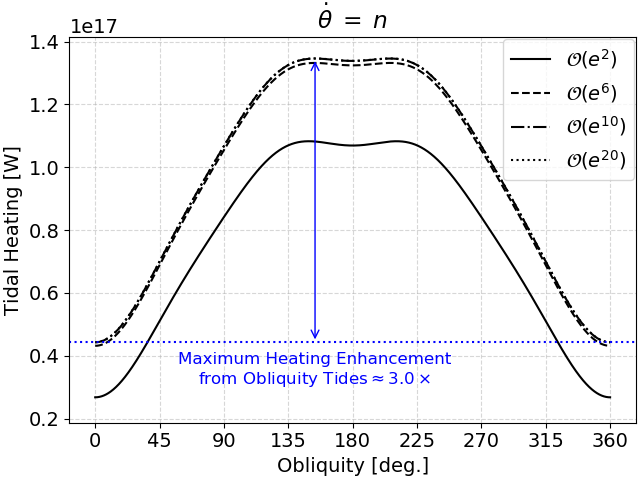

153.71398437921715


In [71]:
obliquity_variation_eccentricity_truncation(TRAPPIST1_e, TRAPPIST1, eccentricity=0.3,
                                            target_viscosity=rock_viscosity, target_shear=rock_shear,
                                            target_rheo='Sundberg-Cooper', double_plot=False,
                                            add_save_name='LargeEccen')

#### Very Large Eccentricity, 0.6

In [ ]:
obliquity_variation_eccentricity_truncation(TRAPPIST1_e, TRAPPIST1, eccentricity=0.6,
                                            target_viscosity=rock_viscosity, target_shear=rock_shear,
                                            target_rheo='Sundberg-Cooper', double_plot=False,
                                            add_save_name='VeryLargeEccen')

## Higher Order l Comparison

In [ ]:
def higher_order_l_compare(object1_dict, object2_dict,
                           obj1_viscosity=ice_viscosity, obj1_shear=ice_shear, obj1_rheology='Sundberg-Cooper',
                           obj2_viscosity=ice_viscosity, obj2_shear=ice_shear, obj2_rheology='Sundberg-Cooper',
                           eccentricity_truncation=10,
                           eccentricities=(0.01, 0.6), obj1_obliquity = 0., obj2_obliquity = 0.,
                           zpoints_heating=np.linspace(1, 2., 30), zticks_heating=(1, 1.25, 1.5, 1.75, 2),
                           zpoints_eccen=np.linspace(-2, 2., 30), zticks_eccen=(-2, -1, 0, 1, 2),
                           ztick_names = ('$10^{-2}$', '$10^{-1}$', '$1$', '$10^{1}$', '$10^{2}$'),
#                            zpoints_eccen=50, zticks_eccen=None,
                           add_save_name: str = None, save_fig=auto_save_plots_ck.value):
    
    print('This plot can take a while even at low resolution.')
    order_ls = [2, 3, 7]
    obj1_tidal_calcs = dict()
    obj2_tidal_calcs = dict()
    eccentricity_calcs = dict()
    
    # Pull out information
    obj1_rheology = rheologies[obj1_rheology]
    obj2_rheology = rheologies[obj2_rheology]
    derivative_calc = build_derivative_func(object1_dict, object2_dict)
    
    # Setup Tidal Calcs
    
    for max_order_l in order_ls:
        
        obj1_tidal_calc, _ = \
            build_tide_func(object1_dict, object2_dict, *obj1_rheology, use_ctl_cpl=False,
                            eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=max_order_l)
        
        obj2_tidal_calc, eccentricity_func = \
            build_tide_func(object2_dict, object1_dict, *obj2_rheology, use_ctl_cpl=False,
                            eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=max_order_l)
        
        obj1_tidal_calcs[max_order_l] = obj1_tidal_calc
        obj2_tidal_calcs[max_order_l] = obj2_tidal_calc
        eccentricity_calcs[max_order_l] = eccentricity_func
    
    # Setup Domains
    oned_n, twod_n = get_resolution()
    # This plot can use a ton of memory so its N should be lower than all the other plots.
    twod_n_real = int(math.floor(0.55 * twod_n))
    orbital_period_domain = np.logspace(-1, 1, twod_n_real)
    obj1_spin_period_domain =  np.logspace(-1, 1, twod_n_real)
    
    orbital_freq_domain = days2rads(orbital_period_domain)
    obj1_spin_freq_domain = days2rads(obj1_spin_period_domain)
    
    orbital_freq, obj1_spin_freq = np.meshgrid(orbital_freq_domain, obj1_spin_freq_domain)
    shape = orbital_freq.shape
    orbital_freq = orbital_freq.flatten()
    obj1_spin_freq = obj1_spin_freq.flatten()
    semi_major_axis = orbital_motion2semi_a(orbital_freq, object1_dict['mass'], object2_dict['mass'])
    x = orbital_period_domain
    y = obj1_spin_period_domain
    
    #    Assume object 2 has already spin-synched
    obj2_spin_freq = orbital_freq # 2. * np.pi / (86400. * 2.) * np.ones_like(orbital_freq)
    
    # Setup figures
    #    Heating Figure
    heating_fig = plt.figure(figsize=(6.4*1.5, 6.8*1.5), constrained_layout=True)
    ratios = (.49, .49, .02)
    heating_gs = GridSpec(3, 3, figure=heating_fig, width_ratios=ratios)
    heating_axes = [heating_fig.add_subplot(heating_gs[0, i]) for i in range(2)]
    heating_axes += [heating_fig.add_subplot(heating_gs[1, i]) for i in range(2)]
    heating_axes += [heating_fig.add_subplot(heating_gs[2, i]) for i in range(2)]
    heating_cbs = [heating_fig.add_subplot(heating_gs[i, 2]) for i in range(3)]
    
    for ax_i, ax in enumerate(heating_axes):
        ax.set(xscale='log', yscale='log')
        if ax_i == 0:
            ax.set(ylabel='$l_{max}=2$\nSpin Period [days]', title=f'e={eccentricities[0]}')
            ax.tick_params(labelbottom=False)
        elif ax_i == 1:
            ax.set(title=f'e={eccentricities[1]}')
            ax.tick_params(labelbottom=False, labelleft=False)
        elif ax_i == 2:
            ax.set(ylabel='$l_{max}=3$\nSpin Period [days]')
            ax.tick_params(labelbottom=False)
        elif ax_i == 3:
            ax.tick_params(labelbottom=False, labelleft=False)
        elif ax_i == 4:
            ax.set(ylabel='$l_{max}=7$\nSpin Period [days]', xlabel='Orbital Period [days]')
        elif ax_i == 5:
            ax.set(xlabel='Orbital Period [days]')            
            ax.tick_params(labelleft=False)
            
    #    Eccentricity Figure
    eccen_fig = plt.figure(figsize=(6.4*1.5, 6.8*1.5), constrained_layout=True)
    ratios = (.49, .49, .02)
    eccen_gs = GridSpec(3, 3, figure=eccen_fig, width_ratios=ratios)
    eccen_axes = [eccen_fig.add_subplot(eccen_gs[0, i]) for i in range(2)]
    eccen_axes += [eccen_fig.add_subplot(eccen_gs[1, i]) for i in range(2)]
    eccen_axes += [eccen_fig.add_subplot(eccen_gs[2, i]) for i in range(2)]
    eccen_cbs = [eccen_fig.add_subplot(eccen_gs[i, 2]) for i in range(3)]
    
    for ax_i, ax in enumerate(eccen_axes):
        ax.set(xscale='log', yscale='log')
        if ax_i == 0:
            ax.set(ylabel='$l_{max}=2$\nSpin Period [days]', title=f'e={eccentricities[0]}')
            ax.tick_params(labelbottom=False)
        elif ax_i == 1:
            ax.set(title=f'e={eccentricities[1]}')
            ax.tick_params(labelbottom=False, labelleft=False)
        elif ax_i == 2:
            ax.set(ylabel='$l_{max}=3$\nSpin Period [days]')
            ax.tick_params(labelbottom=False)
        elif ax_i == 3:
            ax.tick_params(labelbottom=False, labelleft=False)
        elif ax_i == 4:
            ax.set(ylabel='$l_{max}=7$\nSpin Period [days]', xlabel='Orbital Period [days]')
        elif ax_i == 5:
            ax.set(xlabel='Orbital Period [days]')            
            ax.tick_params(labelleft=False)
        
    
    case_inputs = {
        (3, eccentricities[0], 0): (heating_axes[2], eccen_axes[2]),
        (3, eccentricities[1], 1): (heating_axes[3], eccen_axes[3]),
        (7, eccentricities[0], 0): (heating_axes[4], eccen_axes[4]),
        (7, eccentricities[1], 1): (heating_axes[5], eccen_axes[5]),
    }
    
    # Calculate baseline (order-l=2)
    obj1_heatings_2 = list()
    dedts_2 = list()
    for e_i, eccentricity in enumerate(eccentricities):
        
        # Calculate Dissipation
        eccentricity_results = eccentricity_calcs[2](eccentricity)
        
        obj1_tidal_heating_2, obj1_partial_derivatives_2, obj1_love_number_2, obj1_negative_imk_2 = \
                obj1_tidal_calcs[2](orbital_freq, obj1_spin_freq, eccentricity_results, obj1_obliquity,
                                    semi_major_axis=semi_major_axis,
                                    shear_modulus=obj1_shear, viscosity=obj1_viscosity)
        obj2_tidal_heating_2, obj2_partial_derivatives_2, obj2_love_number_2, obj2_negative_imk_2 = \
                obj2_tidal_calcs[2](orbital_freq, obj2_spin_freq, eccentricity_results, obj2_obliquity,
                                    semi_major_axis=semi_major_axis,
                                    shear_modulus=obj2_shear, viscosity=obj2_viscosity)
        
        # Calculate Derivatives
        dspin_dt_obj1, dspin_dt_obj2, da_dt, de_dt = \
            derivative_calc(semi_major_axis, orbital_freq, eccentricity,
                            obj1_partial_derivatives_2, obj2_partial_derivatives_2)
        
        # Reshape results and store
        obj1_tidal_heating_2 = obj1_tidal_heating_2.reshape(shape)
        de_dt = de_dt.reshape(shape)
        obj1_heatings_2.append(obj1_tidal_heating_2)
        dedts_2.append(de_dt)
        
        # l=2 data for plots
        heating_data = np.log10(obj1_tidal_heating_2)
        eccen_data_combo = np.log10(np.abs(de_dt))
        
        # Add to plots
        heating_ax = heating_axes[e_i]
        eccen_ax = eccen_axes[e_i]
        
        heating_cb_data_top = heating_ax.contourf(x, y, heating_data, 60, cmap=lajolla_map)        
        eccen_cb_data_top = eccen_ax.contourf(x, y, eccen_data_combo, np.linspace(-8, 3, len(zpoints_eccen)), cmap=lajolla_map)
        for c in eccen_cb_data_top.collections:
            c.set_edgecolor("face")
        for c in heating_cb_data_top.collections:
            c.set_edgecolor("face")
        
        
    # Perform other l-order calculations and add to the plot
    eccen_cb_datas = list()
    for (order_l, eccentricity, order_2_index), (heating_ax, eccen_ax) in case_inputs.items():
        
        # Calculate Dissipation
        eccentricity_results = eccentricity_calcs[order_l](eccentricity)
        
        obj1_tidal_heating, obj1_partial_derivatives, obj1_love_number, obj1_negative_imk = \
                obj1_tidal_calcs[order_l](orbital_freq, obj1_spin_freq, eccentricity_results, obj1_obliquity,
                                          semi_major_axis=semi_major_axis,
                                          shear_modulus=obj1_shear, viscosity=obj1_viscosity)
        
        obj2_tidal_heating, obj2_partial_derivatives, obj2_love_number, obj2_negative_imk = \
                obj2_tidal_calcs[order_l](orbital_freq, obj2_spin_freq, eccentricity_results, obj2_obliquity,
                                          semi_major_axis=semi_major_axis,
                                          shear_modulus=obj2_shear, viscosity=obj2_viscosity)
        
        # Calculate Derivatives
        dspin_dt_obj1, dspin_dt_obj2, da_dt, de_dt = \
            derivative_calc(semi_major_axis, orbital_freq, eccentricity,
                            obj1_partial_derivatives, obj2_partial_derivatives)
        
        # Reshape
        obj1_tidal_heating = obj1_tidal_heating.reshape(shape)
        de_dt = de_dt.reshape(shape)
        
        # Pull out order-2 results and find ratio
        heating_ratio = np.abs(obj1_tidal_heating / obj1_heatings_2[order_2_index])
        eccen_ratio = np.abs(de_dt / dedts_2[order_2_index])
        eccen_ratio = np.log10(eccen_ratio)
        
        ## There are a handful of points above 10^2 for l=7 at very low spin-period. Set this to 10^2 just so the plot is filled out.
        eccen_ratio[eccen_ratio > 2] = 2
        
        # Add to plots
        heating_cb_data = heating_ax.contourf(x, y, heating_ratio, zpoints_heating, cmap=lajolla_map)
        
        eccen_cb_data = eccen_ax.contourf(x, y, eccen_ratio, zpoints_eccen, cmap=cork_map)
        eccen_cb_datas.append(eccen_cb_data)
        
        for c in eccen_cb_data.collections:
            c.set_edgecolor("face")
        for c in heating_cb_data.collections:
            c.set_edgecolor("face")
        
    # Add Colorbars
    for cb_i, cb_ax in enumerate(heating_cbs):
        if cb_i == 0:
            cb = plt.colorbar(heating_cb_data_top, pad=0.05, cax=cb_ax)
            cb.set_label('Tidal Heating [log$_{10}$ W]')
        else:
            cb = plt.colorbar(heating_cb_data, pad=0.05, cax=cb_ax, ticks=zticks_heating)
            cb.set_label('Tidal Heating Ratio')
            
    # Annotations
    eccen_axes[3].annotate("Enhancement at\nLow Orbital Period", (0.4, 4), (0.4, 4),
                           fontsize=12, ha='center')
    eccen_axes[5].annotate("New Modes\nActivated", (0.4, .29), (0.26, 1),
                           arrowprops={'arrowstyle': '-['},
                           fontsize=12, ha='center')
    # Add Colorbars
    for cb_i, cb_ax in enumerate(heating_cbs):
        if cb_i == 0:
            cb = plt.colorbar(heating_cb_data_top, pad=0.05, cax=cb_ax)
            cb.set_label('Tidal Heating [log$_{10}$ W]')
        else:
            cb = plt.colorbar(heating_cb_data, pad=0.05, cax=cb_ax, ticks=zticks_heating)
            cb.set_label('Tidal Heating Ratio')
            
    for cb_i, cb_ax in enumerate(eccen_cbs):
        if cb_i == 0:
            cb = plt.colorbar(eccen_cb_data_top, pad=0.05, cax=cb_ax, ticks=[-8, -6, -4, -2, 0, 2])
            cb.set_label('$|\\dot{e}|$ [yr$^{-1}$]')
            cb.ax.set_yticklabels(['$10^{-8}$', '$10^{-6}$', '$10^{-4}$', '$10^{-2}$', '$1$', '$10^{2}$'])
        else:
            cb2 = plt.colorbar(eccen_cb_datas[cb_i-1], pad=0.05, cax=eccen_cbs[cb_i], ticks=zticks_eccen)
            cb2.set_label('$|\\dot{e}|$ Ratio')
            cb2.ax.set_yticklabels(ztick_names)
        
    if save_fig:
        save_name = analysis_version_save + 'OrderlComparePlot_' + object1_dict['name'] + '_' + object2_dict['name']
        if add_save_name is not None:
            save_name = save_name + '_' + add_save_name

        heating_fig.savefig(save_name + '_HeatingRatio.pdf')
        eccen_fig.savefig(save_name + '_dedtRatio.pdf')
        heating_fig.savefig(save_name + '_HeatingRatio.png', dpi=300)
        eccen_fig.savefig(save_name + '_dedtRatio.png', dpi=300)

    plt.show()

In [ ]:
t_i = time.time()
higher_order_l_compare(pluto, charon,
                       obj1_viscosity=ice_viscosity, obj1_shear=ice_shear, obj1_rheology='Sundberg-Cooper',
                           obj2_viscosity=ice_viscosity, obj2_shear=ice_shear, obj2_rheology='Sundberg-Cooper',
                           eccentricity_truncation=20,
                           eccentricities=(0.05, 0.6), obj1_obliquity = 0., obj2_obliquity = 0., add_save_name='IceVisco')
print(f'Order l time take: {time.time() - t_i:0.1f}')

### 1-D Comparison

In [ ]:
def higher_order_l_compare_1d(object1_dict, object2_dict, obj1_spin_period=1., obj2_spin_period=2.5,
                           obj1_viscosity=ice_viscosity, obj1_shear=ice_shear, obj1_rheology='Sundberg-Cooper',
                           obj2_viscosity=ice_viscosity, obj2_shear=ice_shear, obj2_rheology='Sundberg-Cooper',
                           eccentricity_truncation=20,
                           eccentricities=(0.01, 0.6), obj1_obliquity = 0., obj2_obliquity = 0.,
                           add_save_name: str = None, save_fig=auto_save_plots_ck.value):
    
    order_ls = [2, 3, 7]
    obj1_tidal_calcs = dict()
    obj2_tidal_calcs = dict()
    eccentricity_calcs = dict()
    
    # Pull out information
    obj1_name = object1_dict['name']
    obj2_name = object2_dict['name']
    obj1_rheology = rheologies[obj1_rheology]
    obj2_rheology = rheologies[obj2_rheology]
    derivative_calc = build_derivative_func(object1_dict, object2_dict)
    
    # Setup Tidal Calcs
    
    for max_order_l in order_ls:
        
        obj1_tidal_calc, _ = \
            build_tide_func(object1_dict, object2_dict, *obj1_rheology, use_ctl_cpl=False,
                            eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=max_order_l)
        
        obj2_tidal_calc, eccentricity_func = \
            build_tide_func(object2_dict, object1_dict, *obj2_rheology, use_ctl_cpl=False,
                            eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=max_order_l)
        
        obj1_tidal_calcs[max_order_l] = obj1_tidal_calc
        obj2_tidal_calcs[max_order_l] = obj2_tidal_calc
        eccentricity_calcs[max_order_l] = eccentricity_func
    print('Compiling Finished!')
        
    
    # Setup Domains
    oned_n, twod_n = get_resolution()
    spin_freq_obj1 = days2rads(obj1_spin_period)
    spin_freq_obj2 = days2rads(obj2_spin_period)
    orbital_period_domain = np.linspace(0.1, 9, oned_n)
    orbital_freq = days2rads(orbital_period_domain)
    orbital_freq_res1 = spin_freq_obj1 / np.asarray([0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6., 6.5, 7.])
    orbital_freq_res2 = spin_freq_obj2 / np.asarray([0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6., 6.5, 7.])
    orbital_freq_res1[rads2days(orbital_freq_res1) > 8] = 9
    orbital_freq_res2[rads2days(orbital_freq_res2) > 8] = 9
    orbital_freq = np.concatenate((orbital_freq, orbital_freq_res1, orbital_freq_res2))
    orbital_freq = np.sort(orbital_freq)
    semi_major_axis = orbital_motion2semi_a(orbital_freq, object1_dict['mass'], object2_dict['mass'])
    x = rads2days(orbital_freq)
    spin_freq_obj1 *= np.ones_like(orbital_freq)
    spin_freq_obj2 *= np.ones_like(orbital_freq)
    
    # Setup figures
    #    Heating Figure
    heating_fig = plt.figure(figsize=(6.4*1.5, 4.8*1.5), constrained_layout=True)
    ratios = (.5, .5)
    heating_gs = GridSpec(2, 2, figure=heating_fig, width_ratios=ratios)
    heating_axes = [heating_fig.add_subplot(heating_gs[0, i]) for i in range(2)]
    heating_axes += [heating_fig.add_subplot(heating_gs[1, i]) for i in range(2)]
    
    for ax_i, ax in enumerate(heating_axes):
        ax.set(xscale='linear', yscale='linear')
        ax.axvline(x=obj1_spin_period, c='g', dashes=[5, 8])
        ax.axvline(x=obj2_spin_period, c='m', dashes=[5, 8])
        if ax_i == 0:
            ax.set(ylabel='$l=3$\nTidal Heating Ratio (to $l=2$)', title=f'e={eccentricities[0]}')
            ax.tick_params(labelbottom=False)
        elif ax_i == 1:
            ax.set(title=f'e={eccentricities[1]}')
            ax.tick_params(labelbottom=False, labelleft=False)
        elif ax_i == 2:
            ax.set(ylabel='$l=7$\nTidal Heating Ratio (to $l=3$)', xlabel='Orbital Period [days]')
            # Object Text
            t1 = ax.text(obj1_spin_period - 1., 1.3, f'{obj1_name}', {'color': 'g', 'fontsize': 12},
                 horizontalalignment='left',
                 verticalalignment='center',
                 rotation=30)
            t2 = ax.text(obj2_spin_period, 1.3, f'{obj2_name}', {'color': 'm', 'fontsize': 12},
                 horizontalalignment='left',
                 verticalalignment='center',
                 rotation=30)
        else:
            ax.set(xlabel='Orbital Period [days]')            
            ax.tick_params(labelleft=False)
            
    #    Eccentricity Figure
    eccen_fig = plt.figure(figsize=(6.4*1.5, 4.8*1.5), constrained_layout=True)
    ratios = (.5, .5)
    eccen_gs = GridSpec(2, 2, figure=eccen_fig, width_ratios=ratios)
    eccen_axes = [eccen_fig.add_subplot(heating_gs[0, i]) for i in range(2)]
    eccen_axes += [eccen_fig.add_subplot(heating_gs[1, i]) for i in range(2)]
    
    for ax_i, ax in enumerate(eccen_axes):        
        ax.set(xscale='linear', yscale='linear')
        ax.axvline(x=obj1_spin_period, c='g', dashes=[5, 8])
        ax.axvline(x=obj2_spin_period, c='m', dashes=[5, 8])
        # ax.grid(which='both', axis='x')
        if ax_i in [0, 2]:
            ax.set_ylabel('$\dot{e}$ [yr$^{-1}$]')
        else:
            ax.yaxis.set_ticklabels([])
        
        if ax_i == 0:
            ax.set(ylabel='$l=3$\n$\\dot{e}$ Ratio (to $l=2$)', title=f'e={eccentricities[0]}')
            ax.tick_params(labelbottom=False)
        elif ax_i == 1:
            ax.set(title=f'e={eccentricities[1]}')
            ax.tick_params(labelbottom=False, labelleft=False)
        elif ax_i == 2:
            ax.set(ylabel='$l=7$\n$\\dot{e}$ Ratio (to $l=3$)', xlabel='Orbital Period [days]')
            # Object Text
            t1 = ax.text(obj1_spin_period - 1., 6, f'{obj1_name}', {'color': 'g', 'fontsize': 12},
                 horizontalalignment='left',
                 verticalalignment='center',
                 rotation=30)
            t2 = ax.text(obj2_spin_period, 6, f'{obj2_name}', {'color': 'm', 'fontsize': 12},
                 horizontalalignment='left',
                 verticalalignment='center',
                 rotation=30)
        else:
            ax.set(xlabel='Orbital Period [days]')
            ax.tick_params(labelleft=False)
    
    case_inputs = {
        (3, eccentricities[0], 0): (heating_axes[0], eccen_axes[0]),
        (3, eccentricities[1], 1): (heating_axes[1], eccen_axes[1]),
        (7, eccentricities[0], 0): (heating_axes[2], eccen_axes[2]),
        (7, eccentricities[1], 1): (heating_axes[3], eccen_axes[3]),
    }
    
    # Calculate baseline (order-l=2)
    obj1_heatings_2 = list()
    dedts_2 = list()
    
    max_dedt = 0.
    min_dedt = 1.e100
    max_heat = 0.
    min_heat = 1.e100
    for eccentricity in eccentricities:
        
        # Calculate Dissipation
        eccentricity_results = eccentricity_calcs[2](eccentricity)
        
        obj1_tidal_heating_2, obj1_partial_derivatives_2, obj1_love_number_2, obj1_negative_imk_2 = \
                obj1_tidal_calcs[2](orbital_freq, spin_freq_obj1, eccentricity_results, obj1_obliquity,
                                    semi_major_axis=semi_major_axis,
                                    shear_modulus=obj1_shear, viscosity=obj1_viscosity)
        obj2_tidal_heating_2, obj2_partial_derivatives_2, obj2_love_number_2, obj2_negative_imk_2 = \
                obj2_tidal_calcs[2](orbital_freq, spin_freq_obj2, eccentricity_results, obj2_obliquity,
                                    semi_major_axis=semi_major_axis,
                                    shear_modulus=obj2_shear, viscosity=obj2_viscosity)
        
        # Calculate Derivatives
        dspin_dt_obj1, dspin_dt_obj2, da_dt, de_dt = \
            derivative_calc(semi_major_axis, orbital_freq, eccentricity,
                            obj1_partial_derivatives_2, obj2_partial_derivatives_2)
        
        obj1_heatings_2.append(obj1_tidal_heating_2)
        dedts_2.append(de_dt)
        
    # Perform other order calculations and add to the plot
    
    case_i = 0
    for (order_l, eccentricity, order_2_index), (heating_ax, eccen_ax) in case_inputs.items():
        
        # Calculate Dissipation
        eccentricity_results = eccentricity_calcs[order_l](eccentricity)
        
        obj1_tidal_heating, obj1_partial_derivatives, obj1_love_number, obj1_negative_imk = \
                obj1_tidal_calcs[order_l](orbital_freq, spin_freq_obj1, eccentricity, obj1_obliquity,
                                          semi_major_axis=semi_major_axis,
                                          shear_modulus=obj1_shear, viscosity=obj1_viscosity)
        obj2_tidal_heating, obj2_partial_derivatives, obj2_love_number, obj2_negative_imk = \
                obj2_tidal_calcs[order_l](orbital_freq, spin_freq_obj2, eccentricity, obj2_obliquity,
                                          semi_major_axis=semi_major_axis,
                                          shear_modulus=obj2_shear, viscosity=obj2_viscosity)
        
        # Calculate Derivatives
        dspin_dt_obj1, dspin_dt_obj2, da_dt, de_dt = \
            derivative_calc(semi_major_axis, orbital_freq, eccentricity,
                            obj1_partial_derivatives, obj2_partial_derivatives)
        
        # Pull out order-2 results and find ratio
        heating_ratio = obj1_tidal_heating / obj1_heatings_2[order_2_index]
        eccen_ratio = de_dt / dedts_2[order_2_index]
        
        obj1_heatings_2[order_2_index] = obj1_tidal_heating
        dedts_2[order_2_index] = de_dt
        
        # Make eccentriciy work with log plotting (likely to have negatives)
        eccen_ratio_pos, eccen_ratio_neg = neg_array_for_log_plot(eccen_ratio)
        
        max_dedt = max(max_dedt, np.max(np.abs(eccen_ratio)))
        min_dedt = min(min_dedt, np.min(np.abs(eccen_ratio)))
        max_heat = max(max_heat, np.max(np.abs(heating_ratio)))
        min_heat = min(min_heat, np.min(np.abs(heating_ratio)))
        
        # Add to plots
        heating_ax.plot(x, heating_ratio, c='k', ls='-')
        eccen_ax.plot(x, eccen_ratio_pos, c=red, ls='-')
        eccen_ax.plot(x, eccen_ratio_neg, c=blue, ls='-')
        
        # Add Inset
        if case_i == len(case_inputs)-1:
            ax_inset = eccen_ax.inset_axes(bounds=(.5, .5, .45, .45))
            ax_inset.plot(x, eccen_ratio_pos, c=red, ls='-')
            ax_inset.plot(x, eccen_ratio_neg, c=blue, ls='-')
            ax_inset.set(ylim=(0, 2), xlim=(2, 4))
            mark_inset(eccen_ax, ax_inset, loc1=3, loc2=4, fc="none", ec="k", alpha=0.4)
        
        case_i += 1
    
    for ax_i, ax in enumerate(eccen_axes):
        ax.set(ylim=(0, 10))
    for ax_i, ax in enumerate(heating_axes):
        ax.set(ylim=(0.9, 1.5))
    
    
    if save_fig:
        save_name = analysis_version_save + 'OrderlComparePlot1D_' + object1_dict['name'] + '_' + object2_dict['name']
        if add_save_name is not None:
            save_name = save_name + '_' + add_save_name

        heating_fig.savefig(save_name + '_HeatingRatio.pdf')
        eccen_fig.savefig(save_name + '_dedtRatio.pdf')


    plt.show()

In [ ]:
higher_order_l_compare_1d(pluto, charon, obj1_spin_period=1., obj2_spin_period=2.,
                          eccentricities=(0.01, 0.6), obj1_obliquity = 0., obj2_obliquity = 0.,
                          add_save_name=None, save_fig=auto_save_plots_ck.value)

## Interactive

### Order-l Comparison: Eccentricity leads to resonance shifts

In [ ]:
def resonance_shift_interactive(object1_dict, object2_dict,
                                obj1_viscosity=ice_viscosity, obj1_shear=ice_shear, obj1_rheology='Sundberg-Cooper',
                                obj2_viscosity=ice_viscosity, obj2_shear=ice_shear, obj2_rheology='Sundberg-Cooper',
                                eccentricity_truncation=20,
                                obj1_obliquity = 0., obj2_obliquity = 0.,
                                order_l: int = 3, computational_N = None,
                                save_frame: bool = False,
                                add_save_name: str = None, save_fig=auto_save_plots_ck.value):
    
    # Interpret input and setup function
    obj1_rheology = rheologies[obj1_rheology]
    obj2_rheology = rheologies[obj2_rheology]
    derivative_calc = build_derivative_func(object1_dict, object2_dict)
    
    # Setup domains
    if computational_N is None:
        oned_n, twod_n = get_resolution()
        computational_N = oned_n
        
    orbital_period = np.linspace(.5, 40., computational_N)
    orbital_freq = days2rads(orbital_period)
    semi_major_axis = orbital_motion2semi_a(orbital_freq, object1_dict['mass'], object2_dict['mass'])
    x = orbital_period
    
    # Setup plot
    fig, ax = plt.subplots()
    ax.set(xlabel='Orbital Period [days]', ylabel='$\\dot{e}$ Ratio [$l=' + f'{order_l}' + '/l=2$]', ylim=(0, 10))
    # Initialize plot with fake data
    line_pos, = ax.plot(x, np.ones_like(x), c=red)
    line_neg, = ax.plot(x, np.ones_like(x), c=blue)
    obj1_vline = ax.axvline(x=1., ls=':', c=red, alpha=0.5)
    obj2_vline = ax.axvline(x=2., ls=':', c=blue, alpha=0.5)
    
    # Make a directory for frames
    if save_frame and save_fig:
        dir_name = 'eccen_resonance_frames'
        if add_save_name is not None:
            dir_name += add_save_name
        frame_dir = os.path.join(os.getcwd(), dir_name)
        if not os.path.isdir(frame_dir):
            os.mkdir(frame_dir)
    
    # Setup order-l == 2 calculators
    obj1_tidal_calc_2, _ = \
        build_tide_func(object1_dict, object2_dict, *obj1_rheology, use_ctl_cpl=False,
                        eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=2)
    obj2_tidal_calc_2, eccentricity_func_2 = \
        build_tide_func(object2_dict, object1_dict, *obj2_rheology, use_ctl_cpl=False,
                        eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=2)
    
    # Setup the user-defined calculators
    obj1_tidal_calc_l, _ = \
        build_tide_func(object1_dict, object2_dict, *obj1_rheology, use_ctl_cpl=False,
                        eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=order_l)
    obj2_tidal_calc_l, eccentricity_func_l = \
        build_tide_func(object2_dict, object1_dict, *obj2_rheology, use_ctl_cpl=False,
                        eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=order_l)
    
    def resonance_shift(object_1_spin_period, object_2_spin_period, eccentricity):
        
        # Find frequencies
        object1_spin_freq = days2rads(object_1_spin_period)
        object2_spin_freq = days2rads(object_2_spin_period)
        
        # Calculate eccentricity functions
        eccentricity_results_2 = eccentricity_func_2(eccentricity)
        eccentricity_results_l = eccentricity_func_l(eccentricity)
        
        # Calculate l=2 Dissipation
        obj1_tidal_heating_2, obj1_partial_derivatives_2, obj1_love_number_2, obj1_negative_imk_2 = \
                obj1_tidal_calc_2(orbital_freq, object1_spin_freq, eccentricity_results_2, obj1_obliquity,
                                  semi_major_axis=semi_major_axis,
                                    shear_modulus=obj1_shear, viscosity=obj1_viscosity)
        obj2_tidal_heating_2, obj2_partial_derivatives_2, obj2_love_number_2, obj2_negative_imk_2 = \
                obj2_tidal_calc_2(orbital_freq, object2_spin_freq, eccentricity_results_2, obj2_obliquity,
                                  semi_major_axis=semi_major_axis,
                                  shear_modulus=obj2_shear, viscosity=obj2_viscosity)
        
        # Calculate l=2 Derivatives
        dspin_dt_obj1_2, dspin_dt_obj2_2, da_dt_2, de_dt_2 = \
            derivative_calc(semi_major_axis, orbital_freq, eccentricity,
                            obj1_partial_derivatives_2, obj2_partial_derivatives_2)
        
        # Calculate l Dissipation
        obj1_tidal_heating_l, obj1_partial_derivatives_l, obj1_love_number_l, obj1_negative_imk_l = \
                obj1_tidal_calc_l(orbital_freq, object1_spin_freq, eccentricity_results_l, obj1_obliquity,
                                  semi_major_axis=semi_major_axis,
                                  shear_modulus=obj1_shear, viscosity=obj1_viscosity)
        obj2_tidal_heating_l, obj2_partial_derivatives_l, obj2_love_number_l, obj2_negative_imk_l = \
                obj2_tidal_calc_l(orbital_freq, object2_spin_freq, eccentricity_results_l, obj2_obliquity,
                                  semi_major_axis=semi_major_axis,
                                  shear_modulus=obj2_shear, viscosity=obj2_viscosity)
        
        # Calculate l=2 Derivatives
        dspin_dt_obj1_l, dspin_dt_obj2_l, da_dt_l, de_dt_l = \
            derivative_calc(semi_major_axis, orbital_freq, eccentricity,
                            obj1_partial_derivatives_l, obj2_partial_derivatives_l)
        
        # Calculate Ratios
        eccen_ratio = de_dt_l / de_dt_2
        # Make eccentriciy work with log plotting (likely to have negatives)
        eccen_ratio_pos, eccen_ratio_neg = neg_array_for_log_plot(eccen_ratio)
        
        return eccen_ratio_pos, eccen_ratio_neg
    
    def update(object_1_spin_period=2., object_2_spin_period=4., eccentricity=.05):
        
        # Calculate new ratios
        eccen_ratio_pos, eccen_ratio_neg = resonance_shift(object_1_spin_period, object_2_spin_period, eccentricity)
        
        # Update plot
        line_pos.set_ydata(eccen_ratio_pos)
        line_neg.set_ydata(eccen_ratio_neg)
        ax.set(title=f'e={eccentricity:0.2f}, s1={object_1_spin_period:.1f}, s2={object_2_spin_period:0.1f}')
        obj1_vline.set_xdata((object_1_spin_period, object_1_spin_period))
        obj2_vline.set_xdata((object_2_spin_period, object_2_spin_period))
        
        if save_frame and save_fig:
            frame_name = f'eccen_resonance_frame__sp1_{object_1_spin_period:.1f}__sp2' + \
                         f'_{object_2_spin_period:.1f}__e_{eccentricity:0.2f}.png'
            fig.savefig(os.path.join(frame_dir, frame_name), dpi=300)
        
        # Recalculate the plot limits
#         ax.relim()
#         ax.autoscale_view()
        
    interact(update,
         object_1_spin_period=(0.5,10,.25),
         object_2_spin_period=(0.5,10,.25),
         eccentricity=(0.001, 0.9, 0.05))
    

In [ ]:
resonance_shift_interactive(pluto, charon,
                            obj1_viscosity=ice_viscosity, obj1_shear=ice_shear, obj1_rheology='Sundberg-Cooper',
                            obj2_viscosity=ice_viscosity, obj2_shear=ice_shear, obj2_rheology='Sundberg-Cooper',
                            eccentricity_truncation=20,
                            obj1_obliquity=0., obj2_obliquity = 0.,
                            order_l=3, computational_N=10000,
                            save_frame=True,
                            add_save_name=None, save_fig=True)